### Bulk to single-cell decomposition

Here we explore how we can assemble single-cells to form pseudo-bulk as close as possible to our reference bulk samples.

In [ ]:
# Load general Libraries
library(Matrix) ; library(ggplot2) ; library(glmnet)
library(RColorBrewer) ; library(dplyr) ; library(Biobase)
library(IRdisplay) ; library(reshape2) ; library(ggpubr)
library(xbioc) ; library(ComplexHeatmap) ; library(SingleCellExperiment) ;  library(ggpmisc)
library(circlize) ; library(MASS) ; library(abind) ; library(Metrics) 
# deconvolution methods 
library(BayesPrism) ; library(ClimbTheCliff)

### Important functions

In [3]:
# METRICS FUNCTIONS
num <- function(x){ return(as.numeric(as.character(x)))}
flatten <- function(x){return(as.vector(as.matrix(x)))}
mse <- function(tr, pr){ return( sum((tr - pr)^2) / length(tr) ) }
rmse_ <- function(tr, pr, na.rm=F){ 
    if(na.rm){
        sel.obs = (!is.na(tr))&(!is.na(pr))
        return( sqrt( sum((tr[sel.obs] - pr[sel.obs])^2) / length(tr[sel.obs]) ) ) 
    } else {
        return( sqrt( sum((tr - pr)^2) / length(tr) ) ) 
    }
}
scor <- function(tr, pr){ return( cor(tr, pr, method = 'spearman') ) }
pcor <- function(tr, pr){ return( cor(tr, pr, method = 'pearson') ) }
r_square <- function(pr, tr){ return( sign(cor(pr,tr)) * cor(pr,tr)^2 ) }
### Function to retrieve all metrics from Deconvolution vs True cell-type proportion comparison
comp_rows_and_cols <- function(pred_prop, true_prop){
    pc_l = list() ; sc_l = list()
    rsq_l = list(); rmse_l = list()
    # per row metrics:
    for(i in 1:dim(pred_prop)[1]){
        pc_l[[i]] = cor(pred_prop[i,], true_prop[i,], method = 'pearson')
        sc_l[[i]] = cor(pred_prop[i,], true_prop[i,], method = 'spearman')
        rsq_l[[i]] = max(r_square(pred_prop[i,], true_prop[i,]), -1.0)
        rmse_l[[i]] = rmse(pred_prop[i,], true_prop[i,])
    }
    pc_c = list() ; sc_c = list()
    rsq_c = list(); rmse_c = list()
    # per-column metrics:
    for(i in 1:dim(pred_prop)[2]){
        pc_c[[i]] = cor(pred_prop[,i], true_prop[,i], method = 'pearson')
        sc_c[[i]] = cor(pred_prop[,i], true_prop[,i], method = 'spearman')
        rsq_c[[i]] = max(r_square(pred_prop[,i], true_prop[,i]), -1.0)
        rmse_c[[i]] = rmse(pred_prop[,i], true_prop[,i])
    }
    res = list() ; 
    res[[1]] = num(pc_l) ; res[[2]] = num(sc_l)
    res[[3]] = num(rsq_l); res[[4]] = num(rmse_l)
    res[[5]] = num(pc_c) ; res[[6]] = num(sc_c)
    res[[7]] = num(rsq_c); res[[8]] = num(rmse_c)
    # overall metrics:
    res[[9]] = pcor(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    res[[10]] = scor(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    res[[11]] = max(r_square(as.vector(num(pred_prop)), as.vector(num(true_prop))), -1.0)
    res[[12]] = rmse(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    return(res)
}
# METRICS FUNCTIONS
num <- function(x){ return(as.numeric(as.character(x)))}
flatten <- function(x){return(as.vector(as.matrix(x)))}
mse <- function(tr, pr){ return( sum((tr - pr)^2) / length(tr) ) }
rmse <- function(tr, pr){ return( sqrt( sum((tr - pr)^2) / length(tr) ) ) }
scor <- function(tr, pr){ return( cor(tr, pr, method = 'spearman') ) }
pcor <- function(tr, pr){ return( cor(tr, pr, method = 'pearson') ) }
r_square <- function(pr, tr){
    SStot = sum((tr - mean(tr))^2)
    SSres = sum((pr - tr)^2)
    return(1 - SSres / SStot)
}
r_square <- function(pr, tr){
    return( sign(cor(pr,tr))*cor(pr,tr)^2 )
}
### Function to retrieve all metrics from Deconvolution vs True cell-type proportion comparison
comp_rows_and_cols <- function(pred_prop, true_prop){
    pc_l = list() ; sc_l = list()
    rsq_l = list(); rmse_l = list()
    for(i in 1:dim(pred_prop)[1]){
        pc_l[[i]] = cor(pred_prop[i,], true_prop[i,], method = 'pearson')
        sc_l[[i]] = cor(pred_prop[i,], true_prop[i,], method = 'spearman')
        rsq_l[[i]] = max(r_square(pred_prop[i,], true_prop[i,]), -1.0)
        rmse_l[[i]] = rmse(pred_prop[i,], true_prop[i,])
    }
    pc_c = list() ; sc_c = list()
    rsq_c = list(); rmse_c = list()
    for(i in 1:dim(pred_prop)[2]){
        pc_c[[i]] = cor(pred_prop[,i], true_prop[,i], method = 'pearson')
        sc_c[[i]] = cor(pred_prop[,i], true_prop[,i], method = 'spearman')
        rsq_c[[i]] = max(r_square(pred_prop[,i], true_prop[,i]), -1.0)
        rmse_c[[i]] = rmse(pred_prop[,i], true_prop[,i])
    }
    res = list() ; 
    res[[1]] = num(pc_l) ; res[[2]] = num(sc_l)
    res[[3]] = num(rsq_l); res[[4]] = num(rmse_l)
    res[[5]] = num(pc_c) ; res[[6]] = num(sc_c)
    res[[7]] = num(rsq_c); res[[8]] = num(rmse_c)
    res[[9]] = pcor(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    res[[10]] = scor(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    res[[11]] = max(r_square(as.vector(num(pred_prop)), as.vector(num(true_prop))), -1.0)
    res[[12]] = rmse(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    return(res)
}
reformat_strings <- function(vector_string){
    # replace plus and minus (e.g. useful for CD34+, CD34- populations)
    vector_string <- gsub('\\-$', 'minus', vector_string) 
    vector_string <- gsub('\\+', 'plus', vector_string) 
    vector_string <- gsub('\\ ', '\\.', vector_string) 
    # remove all special characters
    vector_string <- gsub('[^[:alnum:] ]','',vector_string)
    return(vector_string)
}
reformat_celltypes <- function(celltype_labels){
    celltype_labels <- reformat_strings(as.vector(celltype_labels))
    celltype_labels <- factor(celltype_labels)
    return(celltype_labels)
}
add_missing_celltypes <- function(tab, celltype_names){
    missing_ct = celltype_names[!celltype_names %in% colnames(tab)]
    if(length(missing_ct)>0){
        for(ct in missing_ct){
            tab_ = cbind(tab, rep(0, dim(tab)[1]))
            colnames(tab_) = c(colnames(tab), ct)
            tab = tab_
        }
    }
    return(tab)
} 
deconvolution_bayesprism <- function(sc, bulks, true_prop, celltype_names){
    myPrism <- new.prism(reference= t(exprs(sc)), 
                         mixture=t(exprs(bulks)), input.type="count.matrix", 
                         cell.type.labels = as.character(sc$cellType), 
                         cell.state.labels = as.character(sc$cellType), 
                         key = NULL,outlier.cut=0.01,outlier.fraction=0.1)
    bp.res <- run.prism(prism = myPrism, n.cores=6)
    bayesprism_prop <- get.fraction (bp=bp.res, which.theta="final",
             state.or.type="type")
    bayesprism_prop = add_missing_celltypes(bayesprism_prop, celltype_names)
    return(as.matrix(bayesprism_prop[,celltype_names]))
}
write_tables_cibersortx <- function(sc, bulks, true_prop, celltype_names, tab_dir){
    # WARNING : the following script only writes tables to be used on CiberSortX website
    sc_mat = exprs(sc)
    colnames(sc_mat) = as.character(sc$cellType) # cell-type labels provided as column names
    write.table(sc_mat , paste0(tab_dir,"/TMP_cibersortx_sc_mat.txt"), sep = '\t', quote=F)
    write.table(exprs(bulks), paste0(tab_dir,"/TMP_cibersortx_pbulks.txt"), sep = '\t', quote=F)
    # Reformulate to add 'Gene' at the start of the file
    #system(paste0('cat <(echo -ne "Gene\t") ',tab_dir,'/TMP_cibersortx_pbulks.txt > ', 
    #              tab_dir, '/cibersortx_pbulks.txt'))
    #system(paste0('cat <(echo -ne "Gene\t") ',tab_dir,'/TMP_cibersortx_sc_mat.txt > ', 
    #              tab_dir, '/cibersortx_sc_mat.txt'))
    # remove temp files
    #system(paste0('rm ',tab_dir, '/TMP_*'))
}
load_tape_prop <- function(tmp_dir, out_dir, celltype_names){
    celltype_names = reformat_celltypes(celltype_names)
    tape_prop = read.csv(paste0(tmp_dir,'/tape_a_prop.csv'), row.names = 'X')
    colnames(tape_prop) = reformat_celltypes(colnames(tape_prop))
    tape_prop = add_missing_celltypes(tape_prop, celltype_names)
    tape_prop = tape_prop[,as.character(celltype_names)]
    write.csv(tape_prop, paste0(out_dir,'/tape_prop.csv'), quote=F)
    return(tape_prop)
}
load_scaden_prop <- function(tmp_dir, out_dir, celltype_names){
    celltype_names = reformat_celltypes(celltype_names)
    scaden_prop = read.csv(paste0(tmp_dir,'/scaden_prop.csv'), row.names = 'X')
    colnames(scaden_prop) = reformat_celltypes(colnames(scaden_prop))
    scaden_prop = add_missing_celltypes(scaden_prop, celltype_names)
    scaden_prop = scaden_prop[,as.character(celltype_names)]
    write.csv(scaden_prop, paste0(out_dir,'/scaden_prop.csv'), quote=F)
    return(scaden_prop)
}
load_all_props <- function(odir, include_cibersortx=FALSE){
    tdir = paste0(odir,'/tmp_tabs')
    true_p = read.csv(paste0(odir, '/true_prop.csv'), row.names='X')
    sample_names = row.names(true_p)
    celltype_names = read.csv(paste0(odir, '/celltype_names.csv'))$x
    climb_p = read.csv(paste0(odir, '/climb_prop.csv'), row.names='X')[,colnames(true_p)]
    climb_dw_p = read.csv(paste0(odir, '/climb_dw_prop.csv'), row.names='X')[,colnames(true_p)]
    bayesprism_p = read.csv(paste0(odir, '/bayesprism_prop.csv'), row.names='X')[,colnames(true_p)]
    music_p = read.csv(paste0(odir, '/music_prop.csv'), row.names='X')[,colnames(true_p)]
    nnls_p = read.csv(paste0(odir, '/nnls_prop.csv'), row.names='X')[,colnames(true_p)]
    rand_p = read.csv(paste0(odir, '/rand_prop.csv'), row.names='X')[,colnames(true_p)]
    bisque_p = read.csv(paste0(odir, '/bisque_prop.csv'), row.names='X')[,colnames(true_p)]
    tape_p = load_tape_prop(tdir, odir, celltype_names)
    scaden_p = load_scaden_prop(tdir, odir, celltype_names)
    if(include_cibersortx){
        csx_p = read.csv(paste0(odir, '/cibersortx_prop.csv'), row.names='Mixture')[,colnames(true_p)]
        all_p = list(as.matrix(climb_dw_p), as.matrix(climb_p), as.matrix(scaden_p), 
                     as.matrix(tape_p), as.matrix(csx_p), as.matrix(bayesprism_p), as.matrix(music_p), 
                     as.matrix(nnls_p), as.matrix(bisque_p), as.matrix(rand_p))
        names(all_p) = c('CLIMB-DW', 'CLIMB', 'Scaden', 'TAPE', 'CiberSortX', 'BayesPrism', 'MuSiC', 'NNLS', 'BisqueRNA', 'Random')
    } else {
        all_p = list(as.matrix(climb_dw_p), as.matrix(climb_p), as.matrix(scaden_p), 
                     as.matrix(tape_p), as.matrix(bayesprism_p), as.matrix(music_p), 
                     as.matrix(nnls_p), as.matrix(bisque_p), as.matrix(rand_p))
        names(all_p) = c('CLIMB-DW', 'CLIMB', 'Scaden', 'TAPE', 'BayesPrism', 'MuSiC', 'NNLS', 'BisqueRNA', 'Random')
    }
    true_prop_cols = colnames(true_prop) ; true_prop_rows = rownames(true_prop)
    message(paste0('Checking that all tables have the same cell-type labels: ',suppressWarnings(all(lapply(all_p, function(x) all(colnames(x) == true_prop_cols))))))
    message(paste0('Checking that all tables has the same sample names: ',suppressWarnings(all(lapply(all_p, function(x) all(rownames(x) == true_prop_rows))))))
    return(all_p)
}                                                                                           
make_all_metrics <- function(all_ps, t_prop){
    all_rs = list()
    for(p in 1:length(all_ps)){
        name_p = names(all_ps)[p]
        all_rs[[name_p]] = suppressWarnings(comp_rows_and_cols(all_ps[[p]], t_prop))
    }
    names(all_rs) = names(all_ps)
    return(all_rs)
}

# Deconvolution of expression from the in-vitro experiment

We evaluated accuracy of deconvoluted expression in 'overall' mode based on the expression profiles of top 20 marker genes for each cell line (totaling 80 markers) defined through standard Seurat scRNA-seq analysis.

In [5]:
# Load single-cell reference
sc.es.invitro = readRDS('data/invitro_experiment/invitro_sc_es.RDS')

In [6]:
# Load bulk rna-seq from mixtures
bulk.es.invitro = readRDS('data/invitro_experiment/invitro_bulk_es.RDS')

In [13]:
# Load bulk RNA-seq from pure cell lines
bulk_pure_lines = read.csv('data/invitro_experiment/bulkrna_pure_cell_lines.csv', row.names = 'X')
cell_line_names = colnames(bulk_pure_lines)
# check we have the right gene names
all(rownames(bulk_pure_lines) == rownames(bulk.es))

[1] TRUE

### Define 20 markers genes for each cell line with Seurat pipeline

In [10]:
library(Seurat)
# We make a Seurat object from ExpressionSet object, define cell type labels
sc.srt.invitro <- CreateSeuratObject(counts = exprs(sc.es.invitro), project = "vg", min.cells = 3, min.features = 200)
Idents(object = sc.srt.invitro) <- sc.es.invitro$cellType
# Seurat pipeline to normalize and scale data
sc.srt.invitro <- NormalizeData(sc.srt.invitro)
sc.srt.invitro <- FindVariableFeatures(sc.srt.invitro, selection.method = "vst", nfeatures = 2000)
sc.srt.invitro <- ScaleData(sc.srt.invitro)
# Iterate over cell subtype and define markers for each cell subtype
celltype_names = as.character(unique(sc.es.invitro$cellType))
markers_l = list() ; markers_top20_l = list()
for(k in 1:length(celltype_names)){
    this_celltype = celltype_names[k]
    markers_l[[k]] = FindMarkers(sc.srt.invitro, ident.1=this_celltype)
    markers_top20_l[[k]] = rownames(head(markers_l[[k]], 20)) # only take top 20
}
# Assemble top 20 markers from all cell line
celltype_markers = unique(do.call(c,markers_top20_l))

Attaching SeuratObject


Attaching package: ‘Seurat’


The following object is masked from ‘package:SummarizedExperiment’:

    Assays


Centering and scaling data matrix



### Launch CLIMB deconvolution of expression

In [7]:
# Launch CLIMB in 'expression' mode
climb_out.invitro = climb(sc.es.invitro, bulk.es.invitro, mode='expression')

EXPRESSION mode: predicting cell-type expression in bulks - requires single-cell coefficients fitted by CLIMB

6169 common genes found between scRNA-seq refererence and bulk datasets

Bulk to single-cell mapping for prediction of cell-type abundance / expression

Cell-type abundance prediction done. 

Starting high-resolution expression deconvolution



In [16]:
# Extract gene expression deconvoluted by CLIMB in overall mode:
climb_expr_overall = climb_out.invitro$expr.overall[celltype_markers,cell_line_names]
# Get ground truth cell line expression for the same set of markers
bulk_pure_lines.markers = bulk_pure_lines[rownames(climb_expr_overall),cell_line_names]

#### Make Figure for ground truth expression from bulk RNA-seq

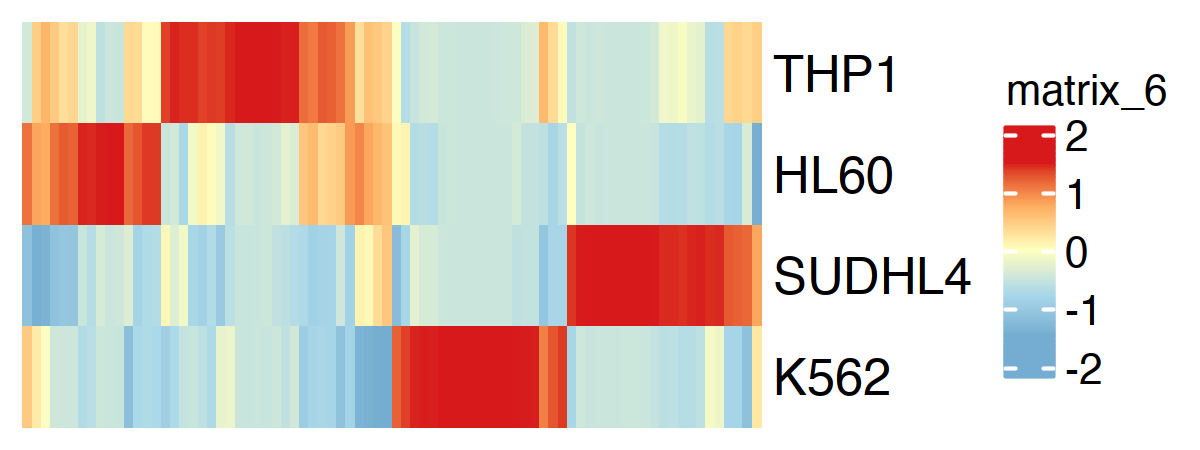

In [26]:
options(repr.plot.width=4, repr.plot.height=1.5, repr.plot.res=300)
col_panel = c('#74add1', "#abd9e9", '#ffffbf','#fdae61', '#d7191c')
col_fun = colorRamp2(c(-1.5,-0.75,0,0.75,1.5), col_panel)
h <- Heatmap(scale(t(log2(bulk_pure_lines.markers+1))), show_column_names = F, 
             show_row_dend = F, show_column_dend = F, col=col_fun)
h <- draw(h)

In [18]:
# Record row / column order from heatmap 
row_h = row_order(h) ; col_h = column_order(h)

#### Make figure for CLIMB deconvoluted expression

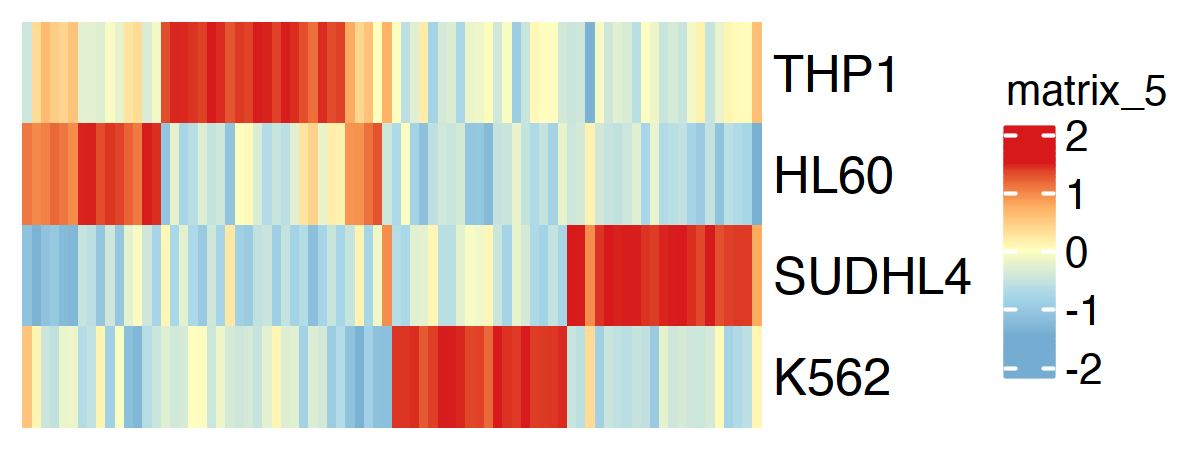

In [25]:
options(repr.plot.width=4, repr.plot.height=1.5, repr.plot.res=300)
h2 <- Heatmap(scale(t(log2(climb_expr_overall+1))), show_column_names = F, show_row_dend = F, show_column_dend = F,
              row_order = row_h, column_order=col_h, col=col_fun)
h2 <- draw(h2)

#### Make scatter plot to compare CLIMB with true cell line expression

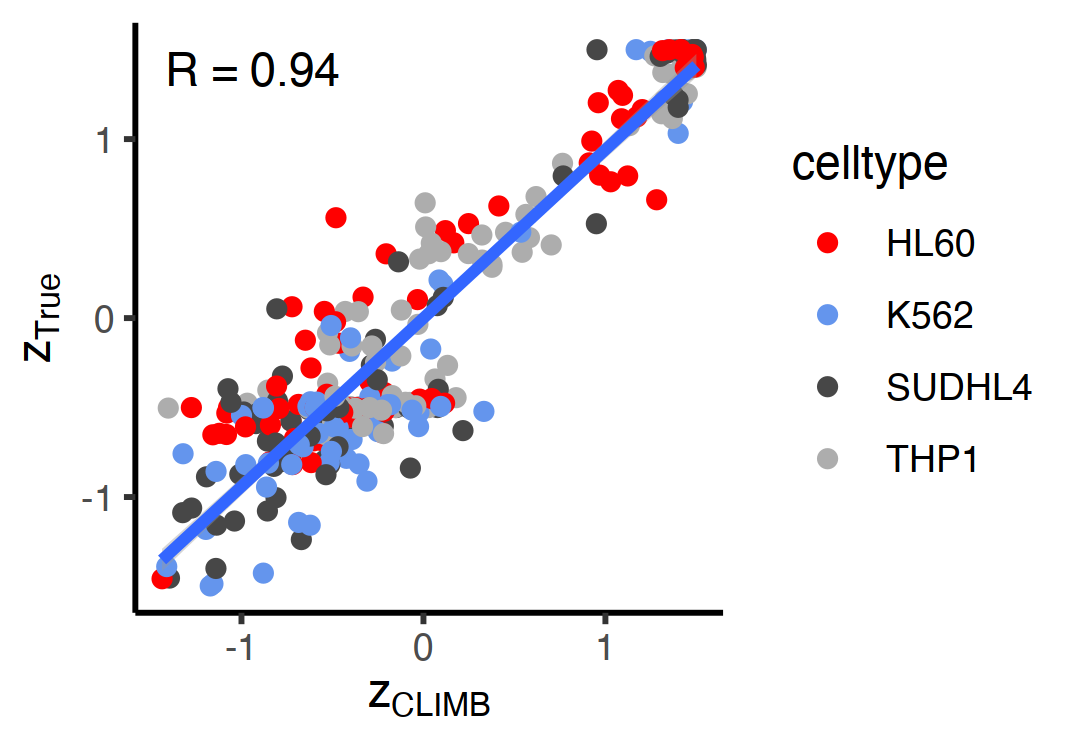

In [29]:
melt_expr_markers = cbind(melt(scale(t(log2(bulk_pure_lines.markers+1)))), melt(scale(t(log2(climb_expr_overall+1)))))[,c(1,2,3,6)]
colnames(melt_expr_markers) = c('celltype', 'gene', 'bulkrna', 'climb_expr')
options(repr.plot.width=3.6, repr.plot.height=2.5, repr.plot.res=300)
ggplot(melt_expr_markers, aes(x=climb_expr, y=bulkrna)) + geom_point(aes(color=celltype)) + 
    stat_poly_line(aes(y=bulkrna, x=climb_expr)) + stat_correlation(aes(y=bulkrna, x=climb_expr)) + 
    theme_classic() + scale_color_manual(values = c('red','cornflowerblue', 'grey28', 'grey68')) +
    xlab(expression(z[CLIMB])) + ylab(expression(z[True]))

### BayesPrism deconvolution

we repeat deconvlution but with BayesPrism method

In [21]:
myPrism <- new.prism(reference= t(exprs(sc.es.invitro)), 
                         mixture=t(exprs(bulk.es.invitro)), input.type="count.matrix", 
                         cell.type.labels = as.character(sc.es.invitro$cellType), 
                         cell.state.labels = as.character(sc.es.invitro$cellType), 
                         key = NULL,outlier.cut=0.01,outlier.fraction=0.1)
bp.res <- run.prism(prism = myPrism, n.cores=6)

number of cells in each cell state 
cell.state.labels
SUDHL4   THP1   HL60   K562 
   551    562    570    659 
No tumor reference is speficied. Reference cell types are treated equally. 
Number of outlier genes filtered from mixture = 3 
Aligning reference and mixture... 
Nornalizing reference... 
Run Gibbs sampling... 
Current time:  2023-08-24 11:22:29 
Estimated time to complete:  2mins 
Estimated finishing time:  2023-08-24 11:23:56 
Start run... 
R Version:  R version 4.2.2 (2022-10-31) 



snowfall 1.84-6.2 initialized (using snow 0.4-4): parallel execution on 6 CPUs.



Stopping cluster




Update the reference matrix ... 


snowfall 1.84-6.2 initialized (using snow 0.4-4): parallel execution on 6 CPUs.



Stopping cluster




Run Gibbs sampling using updated reference ... 
Current time:  2023-08-24 11:24:11 
Estimated time to complete:  2mins 
Estimated finishing time:  2023-08-24 11:25:46 
Start run... 


snowfall 1.84-6.2 initialized (using snow 0.4-4): parallel execution on 6 CPUs.



Stopping cluster




We then process BayesPrism output to generate a 3D array similar as CLIMB's output

In [22]:
# recover deconvoluted expression by BayesPrism:
bayesprism.exp.invitro = data.frame(get.exp(bp.res, state.or.type="state"))
N = dim(bayesprism.exp.invitro)[1] ; G = dim(bayesprism.exp.invitro)[2]/4 ; K = 4
celltype_names = levels(factor(sc.es.invitro$cellType))
### Extract Bayesprism High-Resolution Cell-type Expression
S_bayesprism_invitro = array(rep(0,N*G*K), c(N,G,K))
for(n in 1:N){ # careful to add samples in the right order !
    for(k in 1:K){
        ct = celltype_names[k]
        sel.k = grepl(paste0("\\<",ct,"\\>"), colnames(bayesprism.exp.invitro))
        s_nk = bayesprism.exp.invitro[n,sel.k]
        colnames(s_nk) = gsub(paste0('\\.',ct), '', colnames(s_nk))
        S_bayesprism_invitro[n,,k] = num(s_nk)
    }
}
bp_gene_names = unique(gsub("\\.[^\\.]+$", "",colnames(bayesprism.exp.invitro))) # reformat gene names
bp_gene_names = gsub('\\.', '-', bp_gene_names)
# attribute sample, gene, and sample names
dimnames(S_bayesprism_invitro)[[1]] = colnames(bulk.es.invitro)
dimnames(S_bayesprism_invitro)[[2]] = bp_gene_names
dimnames(S_bayesprism_invitro)[[3]] = celltype_names
# Extract mean expression for each cell line and each marker genes
S_bayesprism_invitro_meanK = colSums(S_bayesprism_invitro, dims = 1)
S_bayesprism_invitro_meanK_markers = S_bayesprism_invitro_meanK[rownames(bulk_pure_lines.markers),]

Draw heatmap of deconvoluted expression by BayesPrism

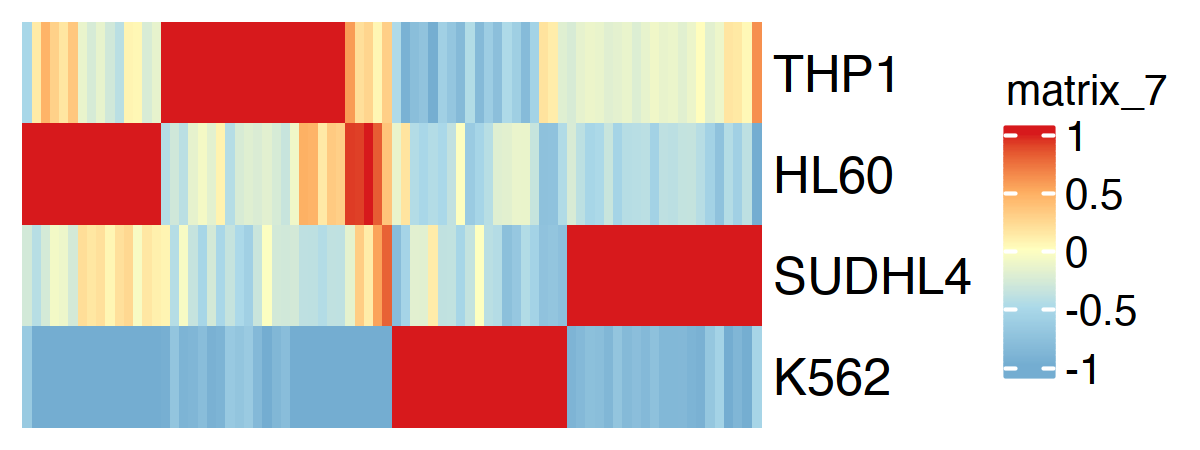

In [34]:
options(repr.plot.width=4, repr.plot.height=1.5, repr.plot.res=300)
Heatmap(scale(t(log2(S_bayesprism_invitro_meanK_markers+1))), show_column_names = F, show_row_dend = F, show_column_dend = F,
              row_order = row_h, column_order=col_h, col=col_fun)

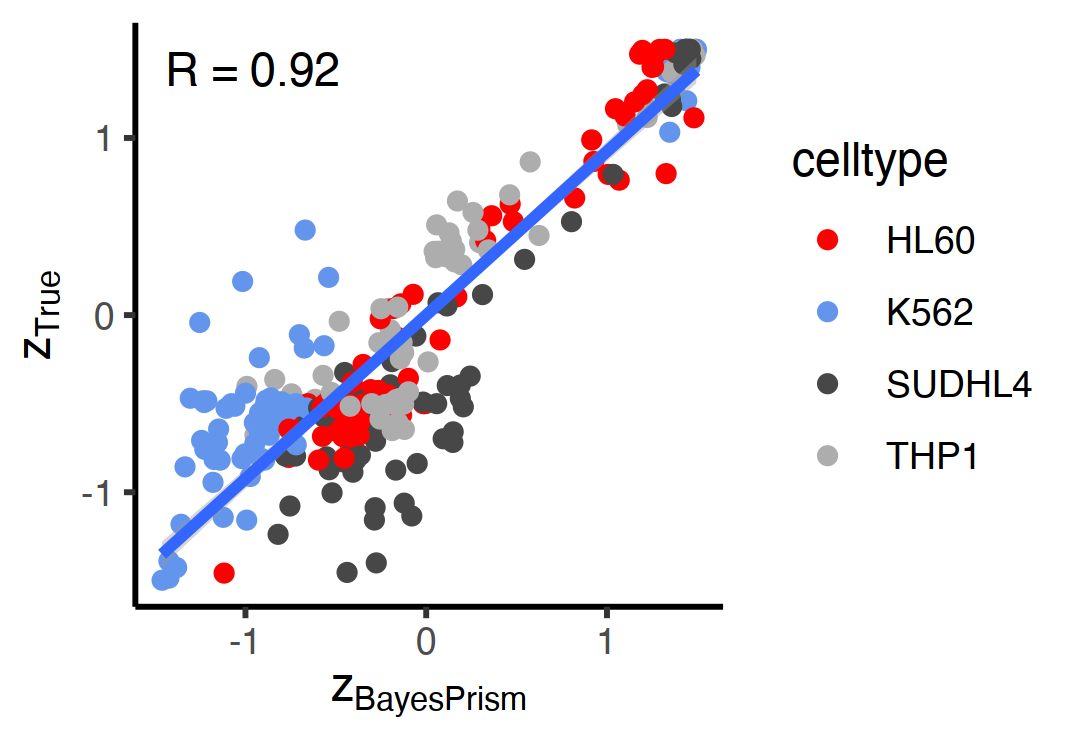

In [28]:
melt_expr_markers.bp = cbind(melt(scale(t(log2(bulk_pure_lines.markers+1)))), 
                             melt(scale(t(log2(S_bayesprism_invitro_meanK_markers+1)))))[,c(1,2,3,6)]

colnames(melt_expr_markers.bp) = c('celltype', 'gene', 'bulkrna', 'bayesprism')

options(repr.plot.width=3.6, repr.plot.height=2.5, repr.plot.res=300)
ggplot(melt_expr_markers.bp, aes(x=bayesprism, y=bulkrna)) + geom_point(aes(color=celltype)) + 
    stat_poly_line(aes(y=bulkrna, x=bayesprism)) + stat_correlation(aes(y=bulkrna, x=bayesprism)) + 
    theme_classic() + scale_color_manual(values = c('red','cornflowerblue', 'grey28', 'grey68')) +
    xlab(expression(z[BayesPrism])) + ylab(expression(z[True]))

### Prepare tables for CiberSortX

This is how we write tables used as input for CiberSortX. To note, tables needs to be processed to add the pattern 'Gene' followed by a tab at the beginning of the files.

In [406]:
out_dir = 'data/expression_deconv/tables'
write_tables_cibersortx <- function(sc, bulks, true_prop, celltype_names, tab_dir){
    # WARNING : the following script only writes tables to be used on CiberSortX website
    sc_mat = exprs(sc)
    colnames(sc_mat) = as.character(sc$cellType) # cell-type labels provided as column names
    write.table(sc_mat , paste0(tab_dir,"/TMP_cibersortx_sc_mat.txt"), sep = '\t', quote=F)
    write.table(exprs(bulks), paste0(tab_dir,"/TMP_cibersortx_pbulks.txt"), sep = '\t', quote=F)
}
# write tables for CiberSortX (still needs to be post-processed by adding 'Gene' in column 1)
write_tables_cibersortx(sc.es.invitro, bulk.es.invitro, pData(bulk.es.invitro), levels(factor(sc.es.invitro$cellType)),
                        out_dir)

### Load CiberSortX group-mode deconvolution

Here we load the processed data as given by CiberSortX

In [31]:
csx_expr = read.csv('data/expression_deconv/tables/cibersortx_expr_overall_invitro_bc.txt', sep='\t', row.names = 'GeneSymbol')
csx_expr = csx_expr[,colnames(bulk_pure_lines.markers)]
csx_expr = csx_expr[rownames(bulk_pure_lines.markers),]

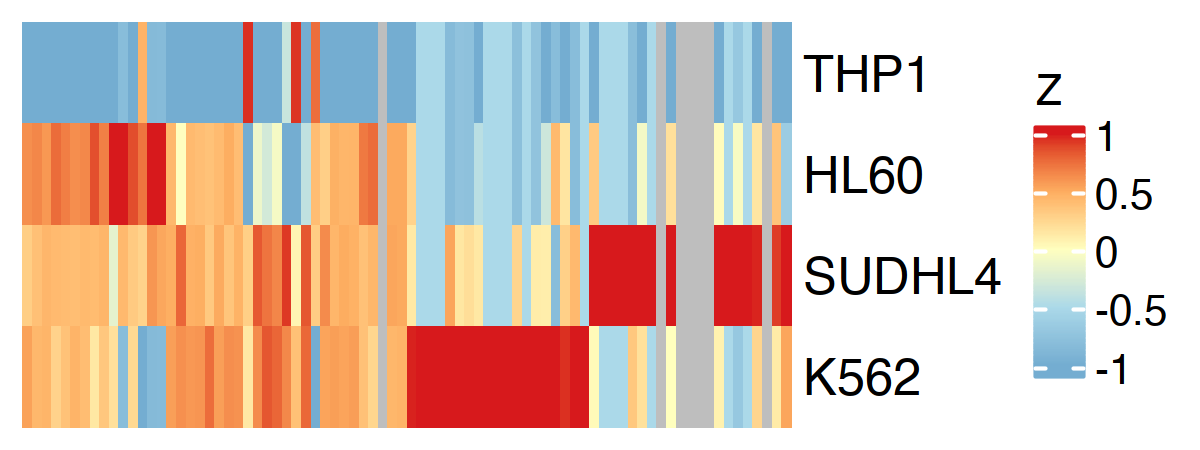

In [33]:
options(repr.plot.width=4, repr.plot.height=1.5)
col_panel = c('#74add1', "#abd9e9", '#ffffbf','#fdae61', '#d7191c')
col_fun = colorRamp2(c(-1,-0.5,0,0.5,1), col_panel)
Heatmap(scale(t(log2(csx_expr+1))), show_column_names = F, show_row_dend = F, show_column_dend = F,
              row_order = row_h, column_order=col_h, col=col_fun, name='Z')

In [35]:
melt_expr_markers.csx = cbind(melt(scale(t(log2(bulk_pure_lines.markers+1)))), 
                             melt(scale(t(log2(csx_expr+1)))))[,c(1,2,3,6)]
colnames(melt_expr_markers.csx) = c('celltype', 'gene', 'bulkrna', 'cibersortx')

Warning message:
“Removed 28 rows containing non-finite values (`stat_poly_line()`).”
Warning message:
“Removed 28 rows containing non-finite values (`sta_corr()`).”
Warning message:
“Removed 28 rows containing missing values (`geom_point()`).”


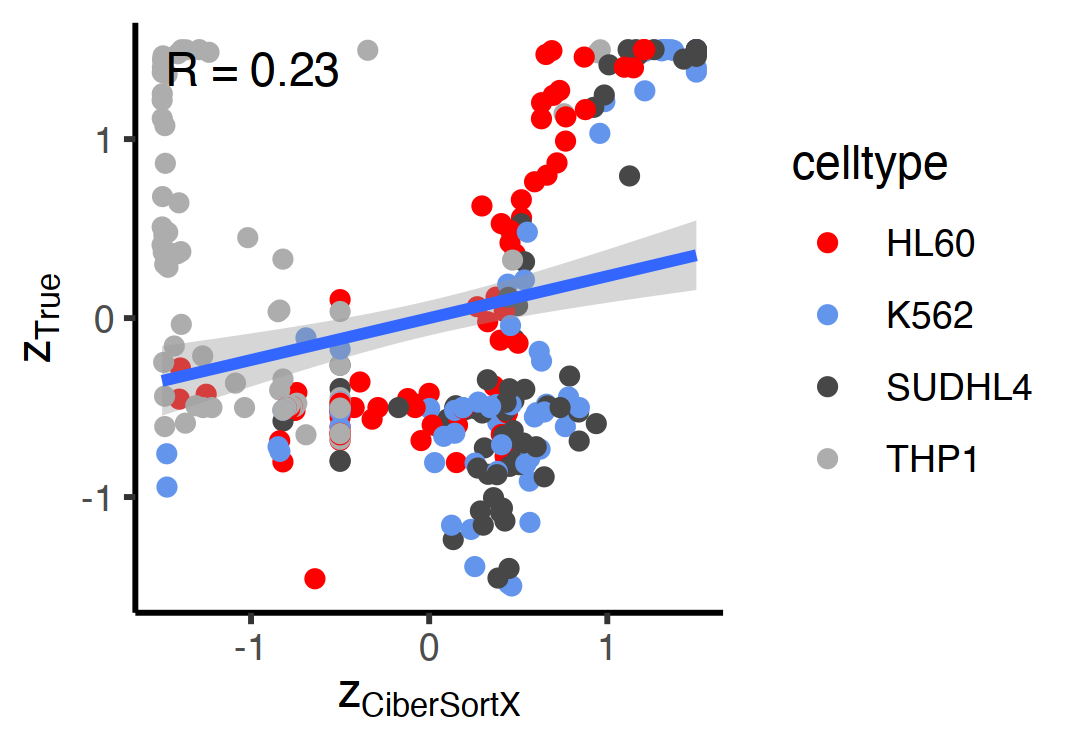

In [36]:
options(repr.plot.width=3.6, repr.plot.height=2.5)
ggplot(melt_expr_markers.csx, aes(x=cibersortx, y=bulkrna)) + geom_point(aes(color=celltype)) + 
    stat_poly_line(aes(y=bulkrna, x=cibersortx)) + stat_correlation(aes(y=bulkrna, x=cibersortx)) + 
    theme_classic() + scale_color_manual(values = c('red','cornflowerblue', 'grey28', 'grey68')) +
    xlab(expression(z[CiberSortX])) + ylab(expression(z[True]))

### Load filtered CiberSortX group-mode deconvolution

In [37]:
csx_expr = read.csv('data/expression_deconv/tables/cibersortx_filtered_expr_overall_invitro_bc.txt', sep='\t', row.names = 'GeneSymbol')
csx_expr = csx_expr[,colnames(bulk_pure_lines.markers)]
csx_expr = csx_expr[rownames(bulk_pure_lines.markers),]

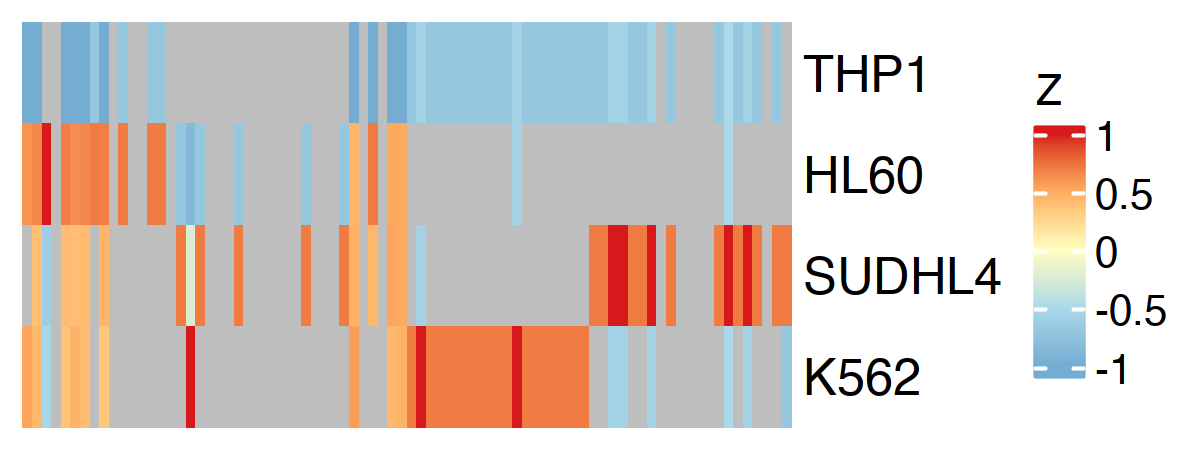

In [38]:
options(repr.plot.width=4, repr.plot.height=1.5)
col_panel = c('#74add1', "#abd9e9", '#ffffbf','#fdae61', '#d7191c')
col_fun = colorRamp2(c(-1,-0.5,0,0.5,1), col_panel)
Heatmap(scale(t(log2(csx_expr+1))), show_column_names = F, show_row_dend = F, show_column_dend = F,
              row_order = row_h, column_order=col_h, col=col_fun, name='Z')

In [39]:
melt_expr_markers.csx.filt = cbind(melt(scale(t(log2(bulk_pure_lines.markers+1)))), 
                             melt(scale(t(log2(csx_expr+1)))))[,c(1,2,3,6)]
colnames(melt_expr_markers.csx.filt) = c('celltype', 'gene', 'bulkrna', 'cibersortx')

Warning message:
“Removed 182 rows containing non-finite values (`stat_poly_line()`).”
Warning message:
“Removed 182 rows containing non-finite values (`sta_corr()`).”
Warning message:
“Removed 182 rows containing missing values (`geom_point()`).”


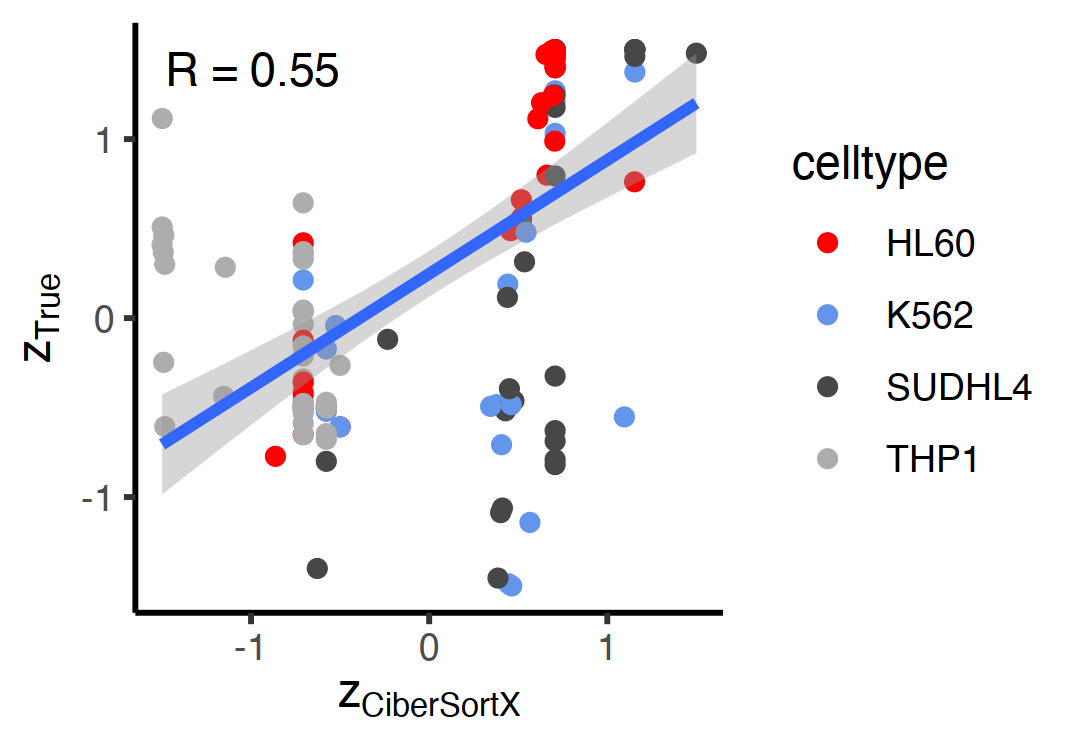

In [40]:
options(repr.plot.width=3.6, repr.plot.height=2.5)
ggplot(melt_expr_markers.csx.filt, aes(x=cibersortx, y=bulkrna)) + geom_point(aes(color=celltype)) + 
    stat_poly_line(aes(y=bulkrna, x=cibersortx)) + stat_correlation(aes(y=bulkrna, x=cibersortx)) + 
    theme_classic() + scale_color_manual(values = c('red','cornflowerblue', 'grey28', 'grey68')) +
    xlab(expression(z[CiberSortX])) + ylab(expression(z[True]))

## Compare CLIMB / BayesPrism / CiberSortX

We compute PCC and RMSE between true and deconvoluted expression for all 3 methods

In [43]:
df_invitro_metrics = data.frame(
           method=c('CLIMB-overall', 'BayesPrism', 'CSX-grouped', 'CSX-grouped-filt'),
           PCC=c( cor(melt_expr_markers$bulkrna, melt_expr_markers$climb_expr, use="complete.obs"),
                  cor(melt_expr_markers.bp$bulkrna, melt_expr_markers.bp$bayesprism, use="complete.obs"),
                  cor(melt_expr_markers.csx$bulkrna, melt_expr_markers.csx$cibersortx, use="complete.obs"),
                  cor(melt_expr_markers.csx.filt$bulkrna, melt_expr_markers.csx.filt$cibersortx, use="complete.obs")),
           RMSE=c(rmse_(melt_expr_markers$bulkrna, melt_expr_markers$climb_expr, na.rm=T),
                  rmse_(melt_expr_markers.bp$bulkrna, melt_expr_markers.bp$bayesprism, na.rm=T),
                  rmse_(melt_expr_markers.csx$bulkrna, melt_expr_markers.csx$cibersortx, na.rm=T),
                  rmse_(melt_expr_markers.csx.filt$bulkrna, melt_expr_markers.csx.filt$cibersortx, na.rm=T)))

In [44]:
df_invitro_metrics

method,PCC,RMSE
<chr>,<dbl>,<dbl>
CLIMB-overall,0.9408859,0.2977771
BayesPrism,0.9238902,0.3378827
CSX-grouped,0.2342279,1.0717547
CSX-grouped-filt,0.5461297,0.8444228


Make plot for Pearson correlation coefficient (PCC) 

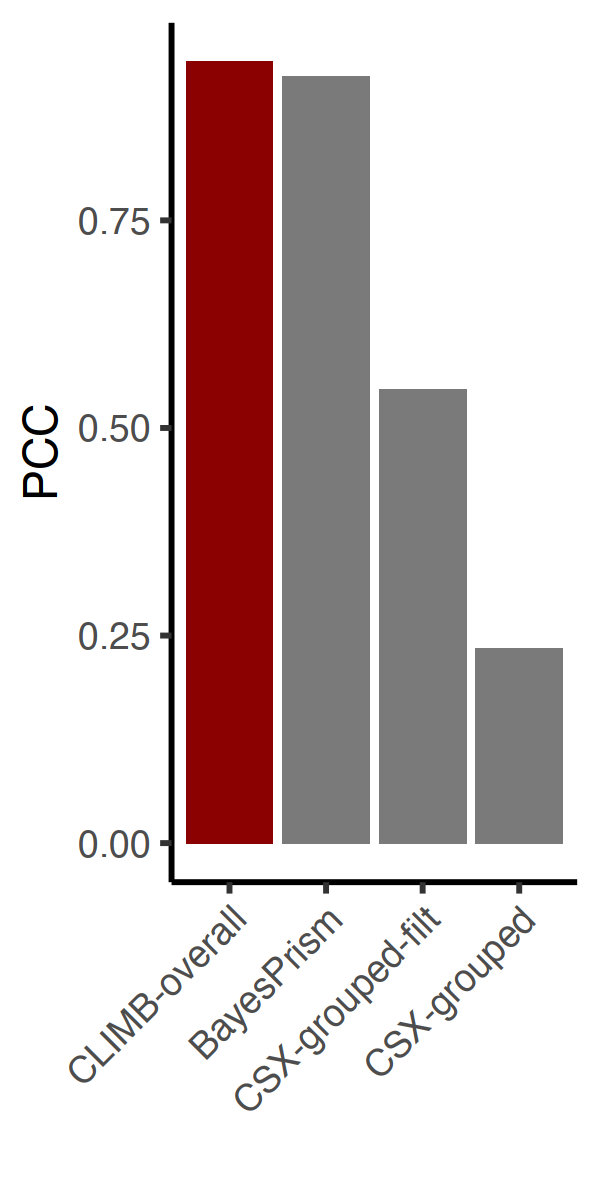

In [45]:
df_invitro_metrics$method = factor(df_invitro_metrics$method,
                                  levels = df_invitro_metrics$method[rev(order(df_invitro_metrics$PCC))])
options(repr.plot.width=2, repr.plot.height=4)
ggplot(df_invitro_metrics, aes(x=method, y=PCC, fill=method)) + geom_col() + theme_classic() +
    theme(axis.text.x = element_text(angle = 45, hjust=1.0, vjust=1.0)) + xlab('') + 
    scale_fill_manual(values = ifelse(grepl('CLIMB', levels(df_invitro_metrics$method)), 'darkred', 'grey48'), guide='none')

Make figure for root mean square error (RMSE)

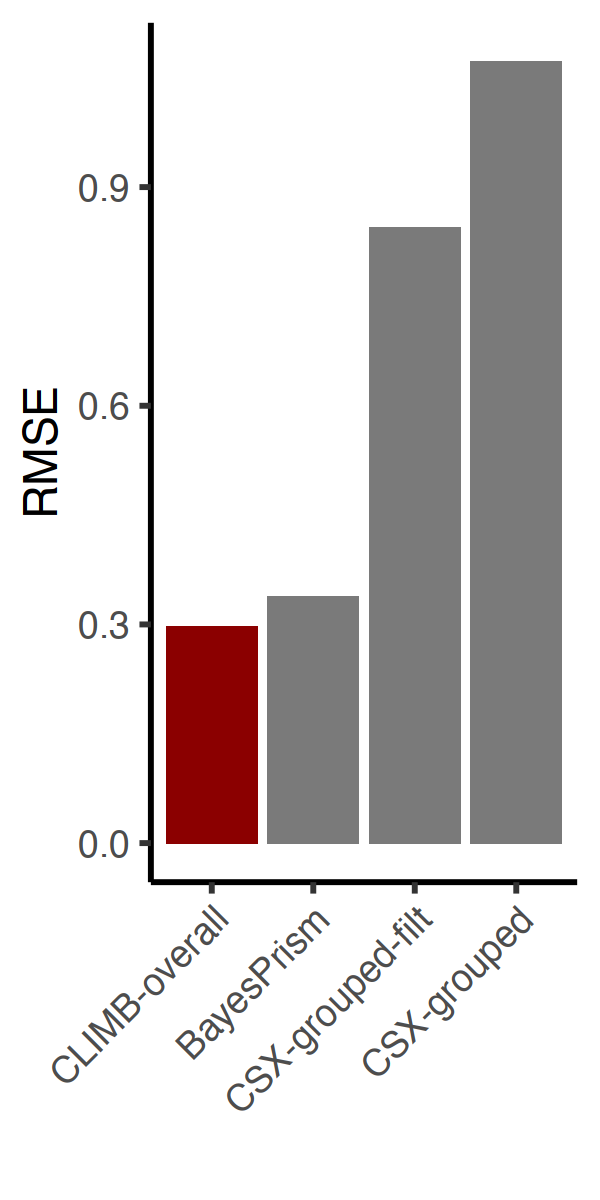

In [46]:
df_invitro_metrics$method = factor(df_invitro_metrics$method,
                                  levels = df_invitro_metrics$method[order(df_invitro_metrics$RMSE)] )
options(repr.plot.width=2, repr.plot.height=4)
ggplot(df_invitro_metrics, aes(x=method, y=RMSE, fill=method)) + geom_col() + theme_classic() +
    theme(axis.text.x = element_text(angle = 45, hjust=1.0, vjust=1.0)) + xlab('') +
    scale_fill_manual(values = ifelse(grepl('CLIMB', levels(df_invitro_metrics$method)), 'darkred', 'grey48'), guide='none')

# Deconvolution of expression with AML samples 

## Launch CLIMB deconvolution of expression on Naldini's bulks - overall mode 

Here we perform a short analysis to compare deconvoluted expression with ground truth using the cross-dataset context of Van Galen > Naldini

In [53]:
# We load Naldini's single-cell data (it will be used to induce over-expression in bulks)
sc.es.na =  readRDS("data/pseudobulks_climb/AML_naldini_sc_es.RDS")
sc.es.na$cellType = factor(reformat_celltypes(sc.es.na$cellType_transfered))

In [54]:
# We load Naldini's pseudo-bulk (made in notebook Fig3_1_preproc_integration.ipynb), 
# used to perform deconvolution without over-expression
bulk.es.na = readRDS("data/pseudobulks_climb/AML_naldini_pbulks_vg_labs.RDS")
true_props.na = pData(bulk.es.na)

In [55]:
# We load the reference single-cell data (Van Galen et al.)
sc.es.vg = readRDS("data/pseudobulks_climb/AML_vangalen_sc_es.RDS")
sc.es.vg$cellType = factor(reformat_celltypes(sc.es.vg$cellType))

In [56]:
# Find gene intersection between Van Galen and Naldini's datasets
sel.genes = intersect(rownames(sc.es.vg), rownames(sc.es.na))
sc.es.vg = sc.es.vg[sel.genes,]
sc.es.na = sc.es.na[sel.genes,]

### Measure true high-resolution expression

This is done using the Naldini's single-cell dataset. The results can be directly loaded in the next cell also

In [51]:
naldini.samples = unique(sc.es.na$SubjectName)
N = length(naldini.samples) ; G = dim(sc.es.na)[1]
K = length(levels(sc.es.na$cellType))
S_true_NA = array(rep(0,N*G*K), c(N,G,K))
for(n in 1:length(naldini.samples)){
    this_sample = naldini.samples[n]
    sc.es.na.sub = sc.es.na[,sc.es.na$SubjectName == this_sample]
    sc_mat = exprs(sc.es.na.sub)
    ct_expr.agg = aggregate(t(exprs(sc_mat)), list(sc.es.na.sub$cellType), sum, drop=FALSE)
    rownames(ct_expr.agg) = ct_expr.agg$`Group.1`
    ct_expr.agg = ct_expr.agg[,-1]
    ct_expr.agg[is.na(ct_expr.agg)] = 0
    S_true_NA[n,,] = t(ct_expr.agg)
}
dimnames(S_true_NA)[[1]] = naldini.samples
dimnames(S_true_NA)[[2]] = rownames(sc.es.na)
dimnames(S_true_NA)[[3]] = levels(sc.es.na$cellType)
# Save high-resolution expression ground truth
#saveRDS(S_true_NA, 'data/expression_deconv/true_expr_vg2na_noOE.RDS')

In [1161]:
S_true_NA = readRDS('data/expression_deconv/true_expr_vg2na_noOE.RDS')

### Launch CLIMB deconvolution

In [57]:
# Uncomment and launch following to launch CLIMB deconvolution in expression mode 
# Alternatively, jump to next cell to load processed results
climb_out = climb(sc.es.vg, bulk.es.na, mode='expression', cancer_pattern = 'like')
climb_expr = climb_out$expr.pred
climb_expr = climb_expr[,,dimnames(climb_expr)[[3]] %in% dimnames(S_true_NA)[[3]]]
# Save CLIMB output object
#saveRDS(climb_out, 'data/expression_deconv/climb_out_vg2na_noOE.RDS')

EXPRESSION mode: predicting cell-type expression in bulks - requires single-cell coefficients fitted by CLIMB

5368 common genes found between scRNA-seq refererence and bulk datasets

Bulk to single-cell mapping for prediction of cell-type abundance / expression

Cell-type abundance prediction done. 

Starting high-resolution expression deconvolution

High-Resolution expression prediction: 1000 genes processed...

High-Resolution expression prediction: 2000 genes processed...

High-Resolution expression prediction: 3000 genes processed...

High-Resolution expression prediction: 4000 genes processed...

High-Resolution expression prediction: 5000 genes processed...



In [72]:
#climb_out = readRDS('data/expression_deconv/climb_out_vg2na_noOE.RDS')
climb_prop = climb_out$props
climb_expr = climb_out$expr.overall

## Look at cancer cell-type signature expression

We compare deconvoluted expression with ground truth for Van Galen > Naldini cross-dataset deconvolution analysis. 

In [98]:
# We select only cancer cell subtypes
cancer_celltypes = reformat_celltypes(colnames(climb_prop)[grepl('like',colnames(climb_prop))])
# We load signature genes from Van Galen et al.
vangalen_signature = read.csv('data/aml_3cohorts/cancer_cell_type_signature.csv')
# we take top 20 for each cell subtype
cancer_celltype_markers = flatten(head(vangalen_signature, 20))
cancer_celltype_markers = Reduce(intersect, list(cancer_celltype_markers, dimnames(S_true_NA)[[2]], rownames(climb_out$expr.overall)))

In [99]:
# Subset true expression to keep only marker genes
S_true_NA.sign  = S_true_NA[1:13,cancer_celltype_markers,dimnames(S_true_NA)[[3]] %in% reformat_celltypes(cancer_celltypes)]
S_true_NA.sign.mean = colMeans(S_true_NA.sign, dims = 1)
S_true_NA.sign.mean = S_true_NA.sign.mean[rowSums(S_true_NA.sign.mean) != 0,]

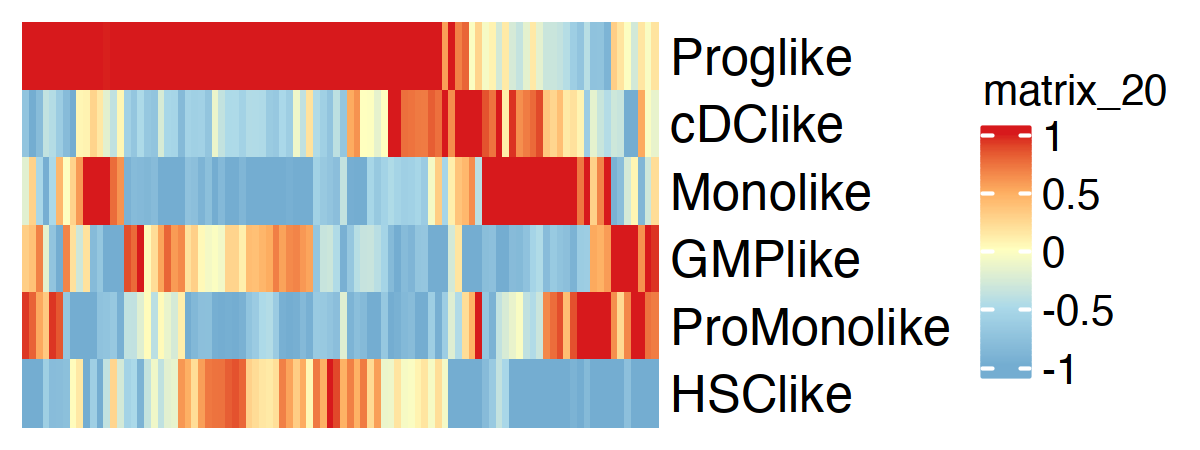

In [102]:
# Make figure for true expression and record row and column names
options(repr.plot.width=4, repr.plot.height=1.5)
col_panel = c('#74add1', "#abd9e9", '#ffffbf','#fdae61', '#d7191c')
col_fun = colorRamp2(c(-1,-0.5,0,0.5,1), col_panel)
h <- Heatmap(scale(t(log2(S_true_NA.sign.mean+1))), show_column_names = F, 
             show_row_dend = F, show_column_dend = F, col=col_fun)
h <- draw(h)
row_h = row_order(h) ; col_h = column_order(h)

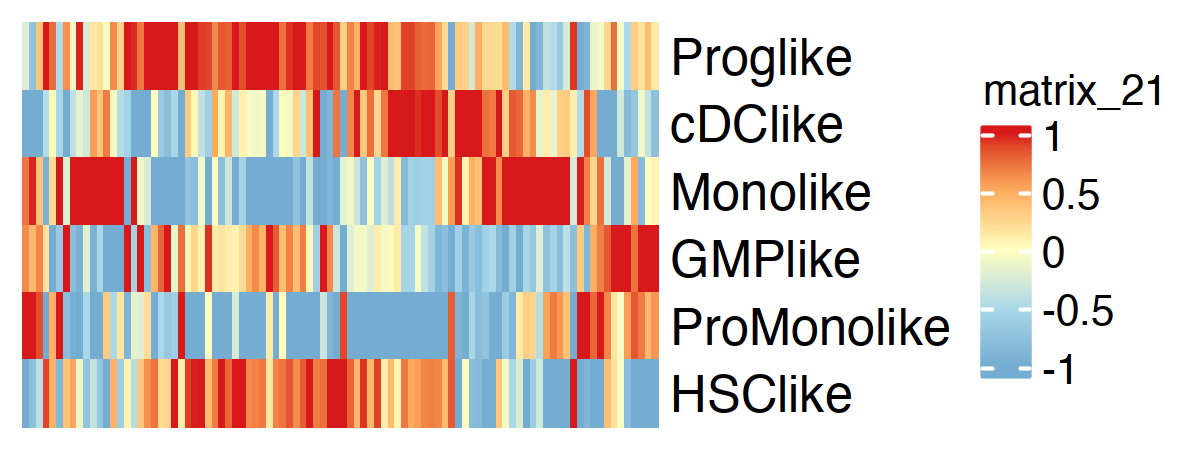

In [103]:
# Make figure for CLIMB's deconvoluted expression 
climb_expr = climb_expr[rownames(S_true_NA.sign.mean),as.character(cancer_celltypes)]
options(repr.plot.width=4, repr.plot.height=1.5)
Heatmap(scale(t(log2(climb_expr[col_h, row_h]+1))), show_column_names = F, show_row_dend = F, show_column_dend = F,
              cluster_rows=F, cluster_columns=F, col=col_fun)

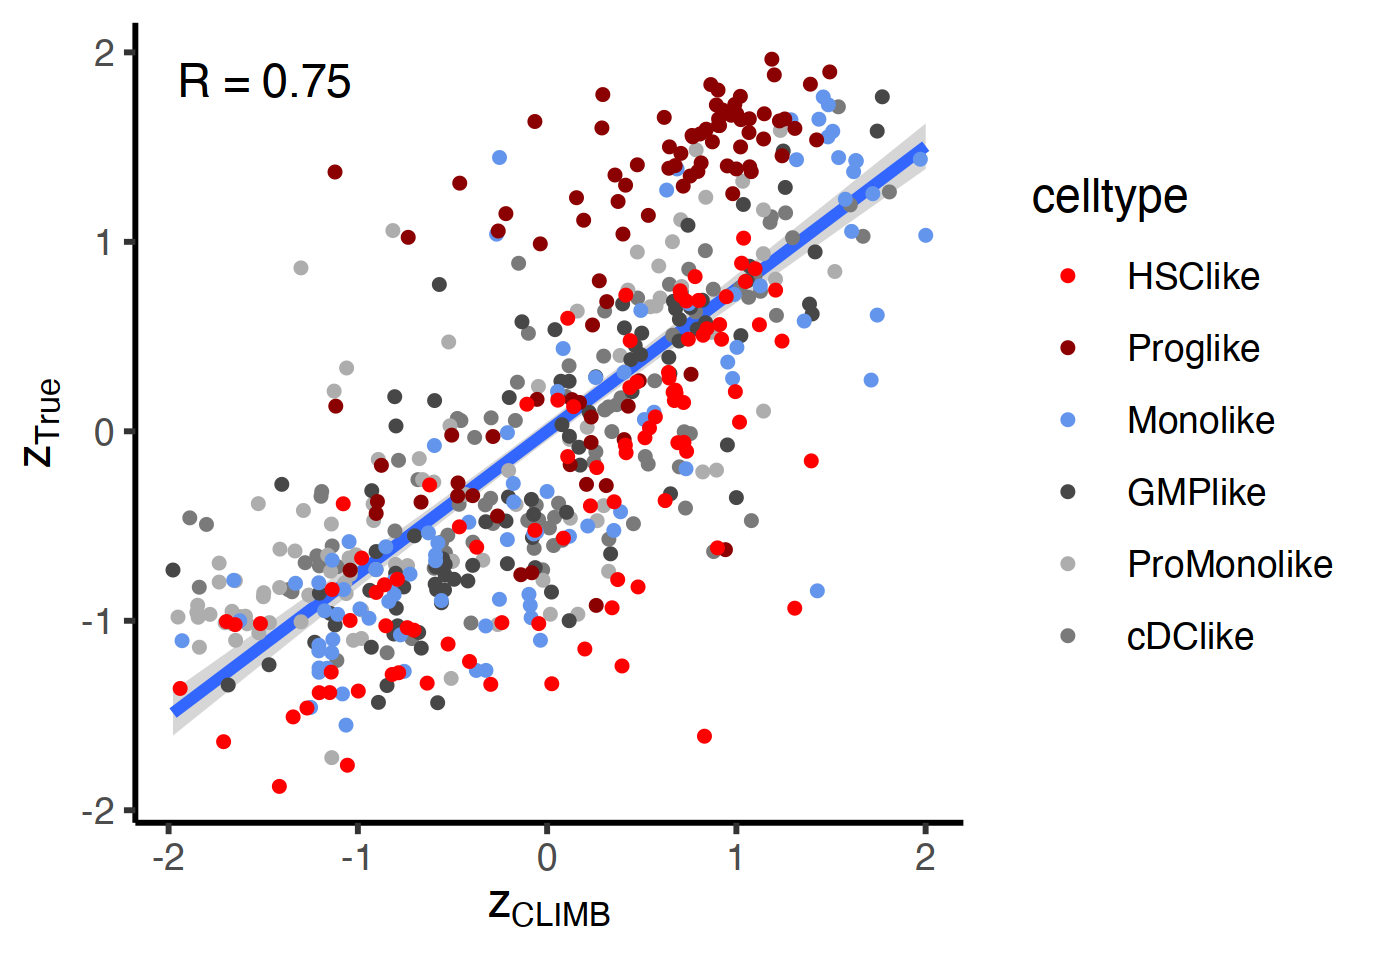

In [105]:
# Make scatter plot to compare deconvoluted expression with ground truth 
melt_markers = cbind(melt(scale(t(log2(S_true_NA.sign.mean+1)))), melt(scale(t(log2(climb_expr+1)))))[,c(1,2,3,6)]
colnames(melt_markers) = c('celltype', 'gene', 'true', 'climb')
melt_markers$celltype = factor(melt_markers$celltype, levels=c('HSClike', 'Proglike', 'Monolike', 'GMPlike', 'ProMonolike', 'cDClike'))
melt_markers = melt_markers[rev(order(melt_markers$celltype)),]
options(repr.plot.width=4.6, repr.plot.height=3.2)
ggplot(melt_markers, aes(y=true, x=climb)) + 
    stat_poly_line(aes(y=true, x=climb)) + stat_correlation(aes(y=true, x=climb)) + 
    geom_point(aes(color=celltype), size=0.8) + theme_classic() +
    scale_color_manual(values = c('red', 'darkred', 'cornflowerblue', 'grey28', 'grey68', 'grey48')) + 
    xlab(expression(z[CLIMB])) + ylab(expression(z[True]))

In [106]:
# We record results accuracy for AML expression deconvolution in overall mode in lists
overall.pcc = list() ; overall.rmse = list()
overall.pcc$climb = cor(melt_markers$true, melt_markers$climb, use="complete.obs")
overall.rmse$climb = rmse_(melt_markers$true, melt_markers$climb, na.rm=T)

### Run BayesPrism on AML with no over-expressed genes

In [107]:
# To run BayesPrism : 
myPrism <- new.prism(reference= t(exprs(sc.es.vg)), 
                         mixture=t(exprs(bulk.es.na)), input.type="count.matrix", 
                         cell.type.labels = as.character(sc.es.vg$cellType), 
                         cell.state.labels = as.character(sc.es.vg$cellType), 
                         key = NULL,outlier.cut=0.01,outlier.fraction=0.1)
bp.res.vg2na <- run.prism(prism = myPrism, n.cores=6)
#saveRDS(bp.res.vg2na, 'results/fig4/bayesprism_out_vg2na_noOE.RDS')

number of cells in each cell state 
cell.state.labels
       ProB     lateEry         CTL     ProMono    earlyEry      Plasma 
         55         172         173         180         213         215 
        cDC         GMP         HSC          NK        Prog        Mono 
        221         242         266         322         326         600 
          T ProMonolike     HSClike     GMPlike     cDClike    Monolike 
        682        1387        1436        1719        1942        2403 
   Proglike 
       2701 
No tumor reference is speficied. Reference cell types are treated equally. 
Number of outlier genes filtered from mixture = 32 
Aligning reference and mixture... 
Nornalizing reference... 
Run Gibbs sampling... 
Current time:  2023-08-24 13:50:32 
Estimated time to complete:  9mins 
Estimated finishing time:  2023-08-24 13:58:37 
Start run... 


snowfall 1.84-6.2 initialized (using snow 0.4-4): parallel execution on 6 CPUs.



Stopping cluster




Update the reference matrix ... 


snowfall 1.84-6.2 initialized (using snow 0.4-4): parallel execution on 6 CPUs.



Stopping cluster




Run Gibbs sampling using updated reference ... 
Current time:  2023-08-24 13:55:22 
Estimated time to complete:  6mins 
Estimated finishing time:  2023-08-24 14:01:10 
Start run... 


snowfall 1.84-6.2 initialized (using snow 0.4-4): parallel execution on 6 CPUs.



Stopping cluster




In [1173]:
# Load pre-processed BayesPrism output:
bp.res.vg2na = readRDS('results/fig4/bayesprism_out_vg2na_noOE.RDS')

In [108]:
# recover deconvoluted expression by BayesPrism:
bayesprism.exp.vg2na = data.frame(get.exp(bp.res.vg2na, state.or.type="state"))
N = dim(bayesprism.exp.vg2na)[1] ; G = dim(bayesprism.exp.vg2na)[2]/19 ; K = 19
celltype_names = levels(factor(sc.es.vg$cellType))
### Compute Bayesprism High-Resolution Cell-type Expression
S_bayesprism_vg2na = array(rep(0,N*G*K), c(N,G,K))
for(n in 1:N){ # careful to add samples in the right order !
    for(k in 1:K){
        ct = celltype_names[k]
        sel.k = grepl(paste0("\\<",ct,"\\>"), colnames(bayesprism.exp.vg2na))
        s_nk = bayesprism.exp.vg2na[n,sel.k]
        colnames(s_nk) = gsub(paste0('\\.',ct), '', colnames(s_nk))
        S_bayesprism_vg2na[n,,k] = num(s_nk)
    }
}
bp_gene_names = unique(gsub("\\.[^\\.]+$", "",colnames(bayesprism.exp.vg2na))) # reformat gene names
bp_gene_names = gsub('\\.', '-', bp_gene_names)
# attribute sample, gene, and sample names
dimnames(S_bayesprism_vg2na)[[1]] = colnames(bulk.es.na)
dimnames(S_bayesprism_vg2na)[[2]] = bp_gene_names
dimnames(S_bayesprism_vg2na)[[3]] = celltype_names
# Compute average per sample
S_bayesprism_vg2na_meanK = colSums(S_bayesprism_vg2na, dims = 1)
S_bayesprism_vg2na_meanK_markers = S_bayesprism_vg2na_meanK[rownames(S_bayesprism_vg2na_meanK) %in% rownames(S_true_NA.sign.mean),]
S_bayesprism_vg2na_meanK_markers = S_bayesprism_vg2na_meanK_markers[,as.character(cancer_celltypes)]
S_bayesprism_vg2na_meanK_markers = data.frame(S_bayesprism_vg2na_meanK_markers)
S_bayesprism_vg2na_meanK_markers = S_bayesprism_vg2na_meanK_markers[rownames(S_true_NA.sign.mean),]

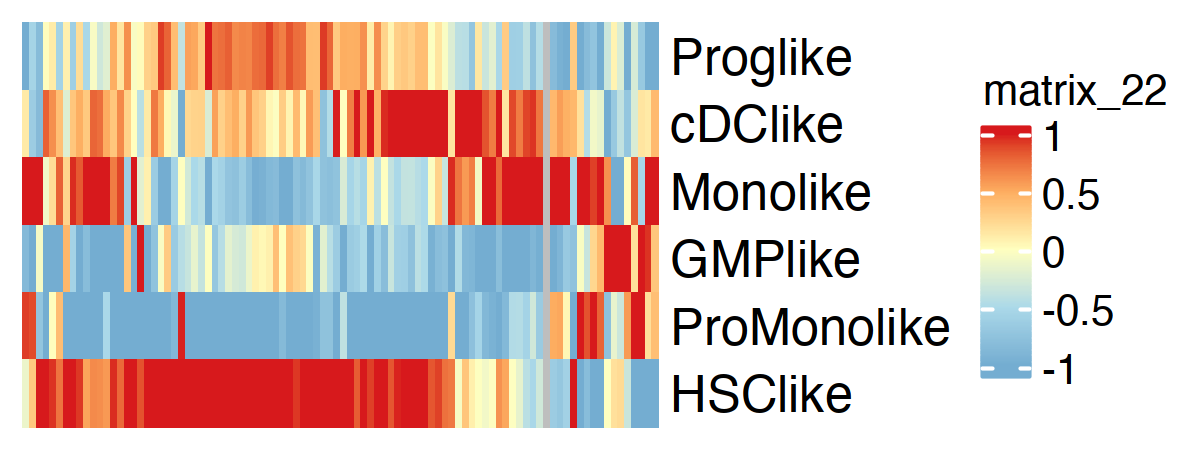

In [113]:
options(repr.plot.width=4, repr.plot.height=1.5)
Heatmap(scale(t(log2(S_bayesprism_vg2na_meanK_markers[col_h,row_h]+1))), show_column_names = F, show_row_dend = F, show_column_dend = F,
              cluster_rows=F, cluster_columns=F, col=col_fun)

Warning message:
“Removed 6 rows containing non-finite values (`stat_poly_line()`).”
Warning message:
“Removed 6 rows containing non-finite values (`sta_corr()`).”
Warning message:
“Removed 6 rows containing missing values (`geom_point()`).”


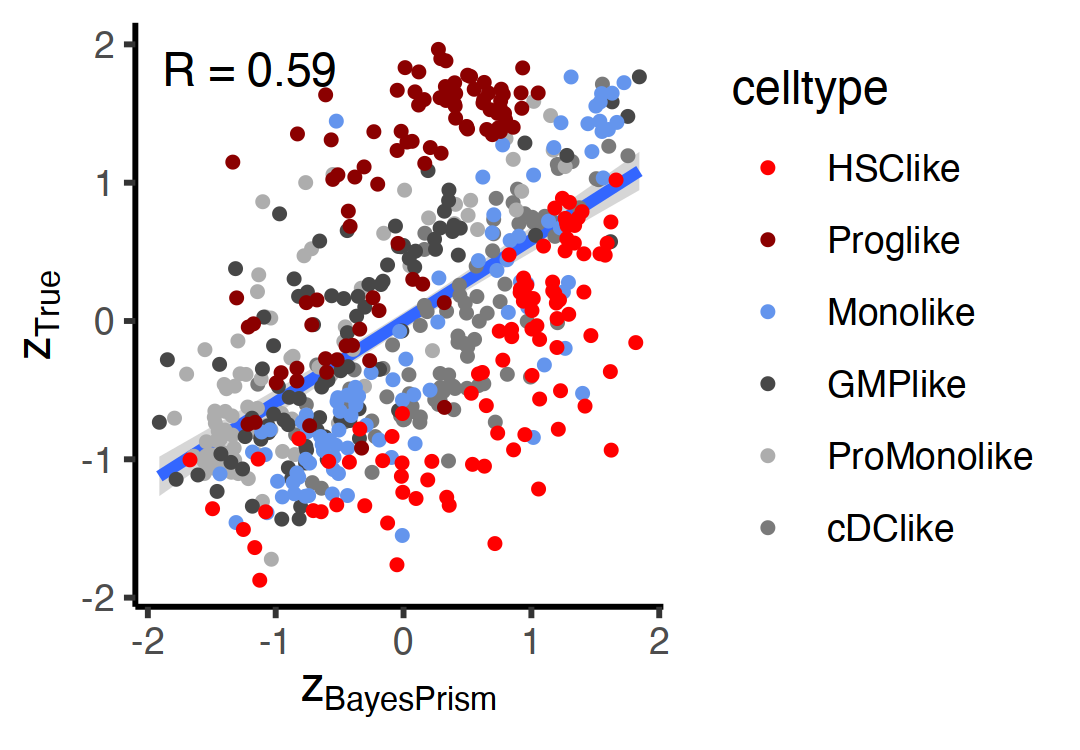

In [114]:
# Make scatter plot 
melt_markers.bp = cbind(melt(scale(t(log2(S_true_NA.sign.mean+1)))), melt(scale(t(log2(S_bayesprism_vg2na_meanK_markers+1)))))[,c(1,2,3,6)]
colnames(melt_markers.bp) = c('celltype', 'gene', 'true', 'bayesprism')
melt_markers.bp$celltype = factor(melt_markers.bp$celltype, levels=c('HSClike', 'Proglike', 'Monolike', 'GMPlike', 'ProMonolike', 'cDClike'))
melt_markers.bp = melt_markers.bp[rev(order(melt_markers.bp$celltype)),]
options(repr.plot.width=3.6, repr.plot.height=2.5)
ggplot(melt_markers.bp, aes(y=true, x=bayesprism)) + 
    stat_poly_line(aes(y=true, x=bayesprism)) + stat_correlation(aes(y=true, x=bayesprism)) + 
    geom_point(aes(color=celltype), size=0.8) + theme_classic() +
    scale_color_manual(values = c('red', 'darkred', 'cornflowerblue', 'grey28', 'grey68', 'grey48')) + 
    xlab(expression(z[BayesPrism])) + ylab(expression(z[True]))

In [115]:
# Record accuracy metrics PCC and RMSE
overall.pcc$bayesprism = cor(melt_markers.bp$true, melt_markers.bp$bayesprism, use="complete.obs")
overall.rmse$bayesprism = rmse_(melt_markers.bp$true, melt_markers.bp$bayesprism, na.rm=T)

### Write tables for CiberSortX and load results

CiberSortX expression deconvolution in group mode cannot run if the number of bulks is smaller than the number of samples. We thus only give cancer cell type in the reference dataset to make it work.

In [57]:
sc.es.vg.onlycancer = sc.es.vg[,grepl('like', sc.es.vg$cellType)]
out_dir = 'data/expression_deconv/tables'
write_tables_cibersortx <- function(sc, bulks, true_prop, celltype_names, tab_dir){
    # WARNING : the following script only writes tables to be used on CiberSortX website
    sc_mat = exprs(sc)
    colnames(sc_mat) = as.character(sc$cellType) # cell-type labels provided as column names
    write.table(sc_mat , paste0(tab_dir,"/TMP_cibersortx_sc_mat_vg2na.txt"), sep = '\t', quote=F)
    write.table(exprs(bulks), paste0(tab_dir,"/TMP_cibersortx_pbulks_vg2na.txt"), sep = '\t', quote=F)
}
# write tables for CiberSortX (still needs to be post-processed by adding 'Gene' in column 1)
write_tables_cibersortx(sc.es.vg.onlycancer, bulk.es.na, pData(bulk.es.na), levels(factor(sc.es.vg$cellType)),out_dir)

### Load CiberSortX results, group-mode with unfiltered genes

In [118]:
csx_expr = read.csv('data/expression_deconv/tables/cibersortx_expr_overall_vg2na_noOE_2.txt', sep='\t', row.names = 'GeneSymbol')
csx_expr = csx_expr[rownames(S_true_NA.sign.mean),]
csx_expr = csx_expr[,colnames(S_true_NA.sign.mean)]

Make heatmap and Scatter plot with unfiltered data

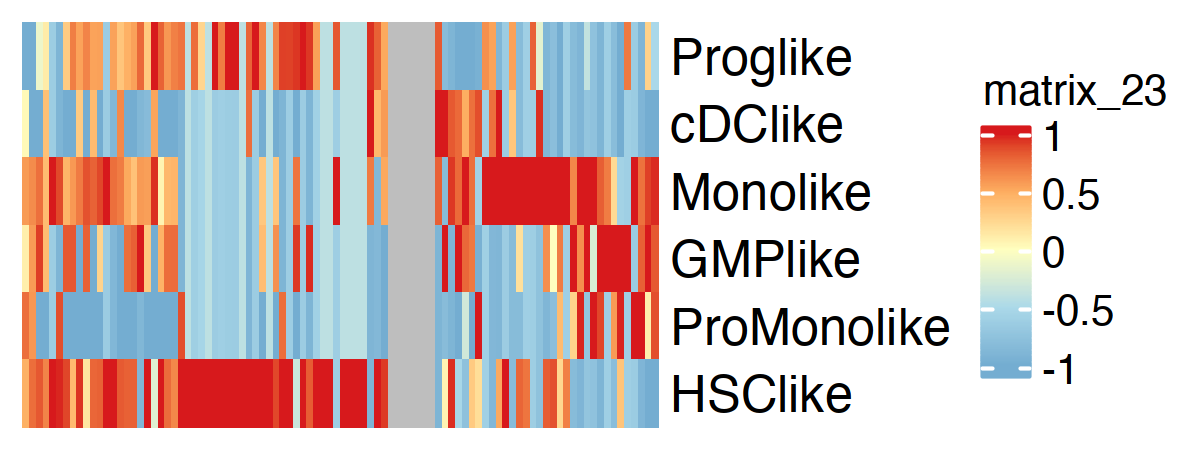

In [119]:
options(repr.plot.width=4, repr.plot.height=1.5)
Heatmap(scale(t(log2(csx_expr[col_h,row_h]+1))), show_column_names = F, show_row_dend = F, show_column_dend = F,
              cluster_rows=F, cluster_columns=F, col=col_fun)

Warning message:
“Removed 42 rows containing non-finite values (`stat_poly_line()`).”
Warning message:
“Removed 42 rows containing non-finite values (`sta_corr()`).”
Warning message:
“Removed 42 rows containing missing values (`geom_point()`).”


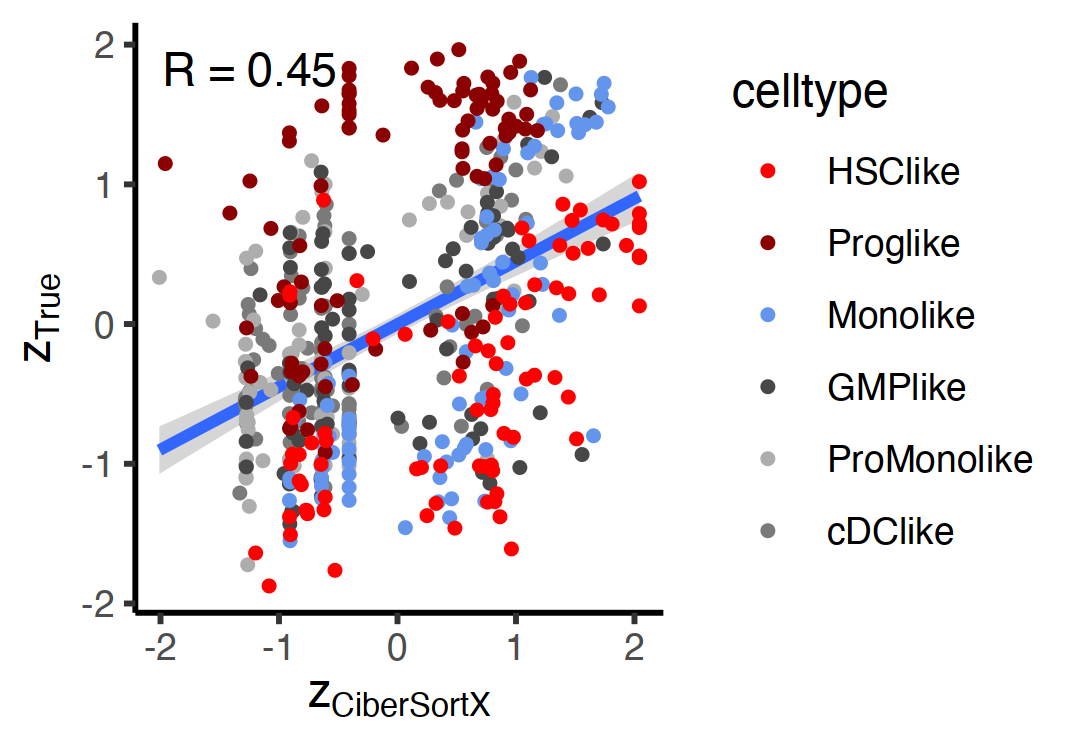

In [121]:
melt_markers.csx = cbind(melt(scale(t(log2(S_true_NA.sign.mean+1)))), melt(scale(t(log2(csx_expr+1)))))[,c(1,2,3,6)]
colnames(melt_markers.csx) = c('celltype', 'gene', 'true', 'cibersortx')
melt_markers.csx$celltype = factor(melt_markers.csx$celltype, levels=c('HSClike', 'Proglike', 'Monolike', 'GMPlike', 'ProMonolike', 'cDClike'))
melt_markers.csx = melt_markers.csx[rev(order(melt_markers.csx$celltype)),]
options(repr.plot.width=3.6, repr.plot.height=2.5)
ggplot(melt_markers.csx, aes(y=true, x=cibersortx)) + 
    stat_poly_line(aes(y=true, x=cibersortx)) + stat_correlation(aes(y=true, x=cibersortx)) + 
    geom_point(aes(color=celltype), size=0.8) + theme_classic() +
    scale_color_manual(values = c('red', 'darkred', 'cornflowerblue', 'grey28', 'grey68', 'grey48')) + 
    xlab(expression(z[CiberSortX])) + ylab(expression(z[True]))

In [122]:
overall.pcc$cibersortx = cor(melt_markers.csx$true, melt_markers.csx$cibersortx, use="complete.obs")
overall.rmse$cibersortx = rmse_(melt_markers.csx$true, melt_markers.csx$cibersortx, na.rm=T)

### Load CiberSortX filtered deconvolution results

In [124]:
csx_expr = read.csv('data/expression_deconv/tables/cibersortx_expr_overall_vg2na_noOE_2_filt.txt', sep='\t', row.names = 'GeneSymbol')
csx_expr = csx_expr[rownames(S_true_NA.sign.mean),]
csx_expr = csx_expr[,colnames(S_true_NA.sign.mean)]

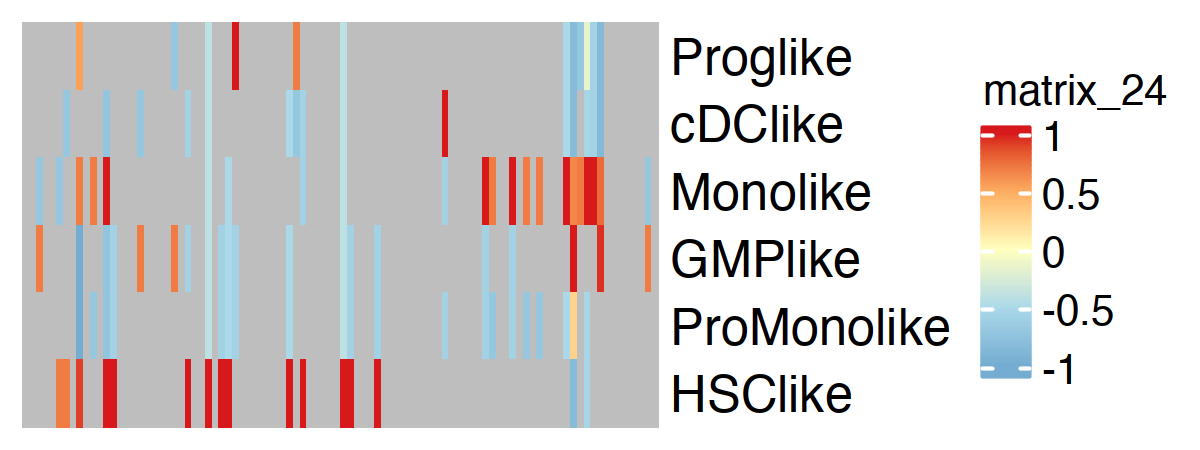

In [125]:
options(repr.plot.width=4, repr.plot.height=1.5)
Heatmap(scale(t(log2(csx_expr[col_h,row_h]+1))), show_column_names = F, show_row_dend = F, show_column_dend = F,
              cluster_rows=F, cluster_columns=F, col=col_fun)

Warning message:
“Removed 458 rows containing non-finite values (`stat_poly_line()`).”
Warning message:
“Removed 458 rows containing non-finite values (`sta_corr()`).”
Warning message:
“Removed 458 rows containing missing values (`geom_point()`).”


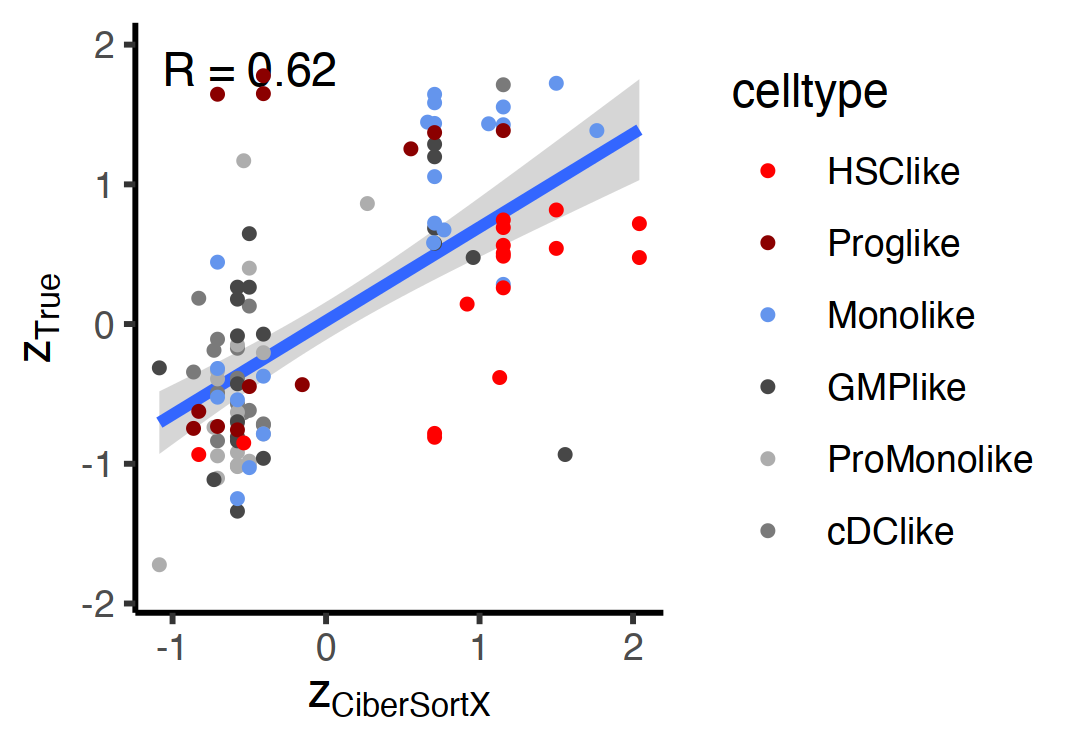

In [126]:
# make scatter plot with filtered data
melt_markers.csx.filt = cbind(melt(scale(t(log2(S_true_NA.sign.mean+1)))), melt(scale(t(log2(csx_expr+1)))))[,c(1,2,3,6)]
colnames(melt_markers.csx.filt) = c('celltype', 'gene', 'true', 'cibersortx')
melt_markers.csx.filt$celltype = factor(melt_markers.csx.filt$celltype, levels=c('HSClike', 'Proglike', 'Monolike', 'GMPlike', 'ProMonolike', 'cDClike'))
melt_markers.csx.filt = melt_markers.csx.filt[rev(order(melt_markers.csx.filt$celltype)),]
options(repr.plot.width=3.6, repr.plot.height=2.5)
ggplot(melt_markers.csx.filt, aes(y=true, x=cibersortx)) + 
    stat_poly_line(aes(y=true, x=cibersortx)) + stat_correlation(aes(y=true, x=cibersortx)) + 
    geom_point(aes(color=celltype), size=0.8) + theme_classic() +
    scale_color_manual(values = c('red', 'darkred', 'cornflowerblue', 'grey28', 'grey68', 'grey48')) + 
    xlab(expression(z[CiberSortX])) + ylab(expression(z[True]))

In [127]:
# Record PCC and RMSE
overall.pcc$cibersortx_filt = cor(melt_markers.csx.filt$true, melt_markers.csx.filt$cibersortx, use="complete.obs")
overall.rmse$cibersortx_filt = rmse_(melt_markers.csx.filt$true, melt_markers.csx.filt$cibersortx, na.rm=T)

### Comparison of CLIMB / BayesPrism / CiberSortX

We know plot the comparative accuracies of all three methods 

In [128]:
df_vg2na_metrics = data.frame(
           method=c('CLIMB-overall', 'BayesPrism', 'CSX-grouped', 'CSX-grouped-filt'),
           PCC=c( cor(melt_markers$true, melt_markers$climb, use="complete.obs"),
                  cor(melt_markers.bp$true, melt_markers.bp$bayesprism, use="complete.obs"),
                  cor(melt_markers.csx$true, melt_markers.csx$cibersortx, use="complete.obs"),
                  cor(melt_markers.csx.filt$true, melt_markers.csx.filt$cibersortx, use="complete.obs")),
           RMSE=c(rmse_(melt_markers$true, melt_markers$climb, na.rm=T),
                  rmse_(melt_markers.bp$true, melt_markers.bp$bayesprism, na.rm=T),
                  rmse_(melt_markers.csx$true, melt_markers.csx$cibersortx, na.rm=T),
                  rmse_(melt_markers.csx.filt$true, melt_markers.csx.filt$cibersortx, na.rm=T)))

In [129]:
df_vg2na_metrics

method,PCC,RMSE
<chr>,<dbl>,<dbl>
CLIMB-overall,0.7522520,0.6425833
BayesPrism,0.5879722,0.8286815
CSX-grouped,0.4490574,0.9582472
CSX-grouped-filt,0.6225348,0.7513735


In [131]:
df_vg2na_metrics$method = factor(df_vg2na_metrics$method,
                                 levels = df_vg2na_metrics$method[rev(order(df_vg2na_metrics$PCC))] )

In [1228]:
#write.csv(df_vg2na_metrics, 'results/fig4/df_vg2na_metrics.csv', quote=F)

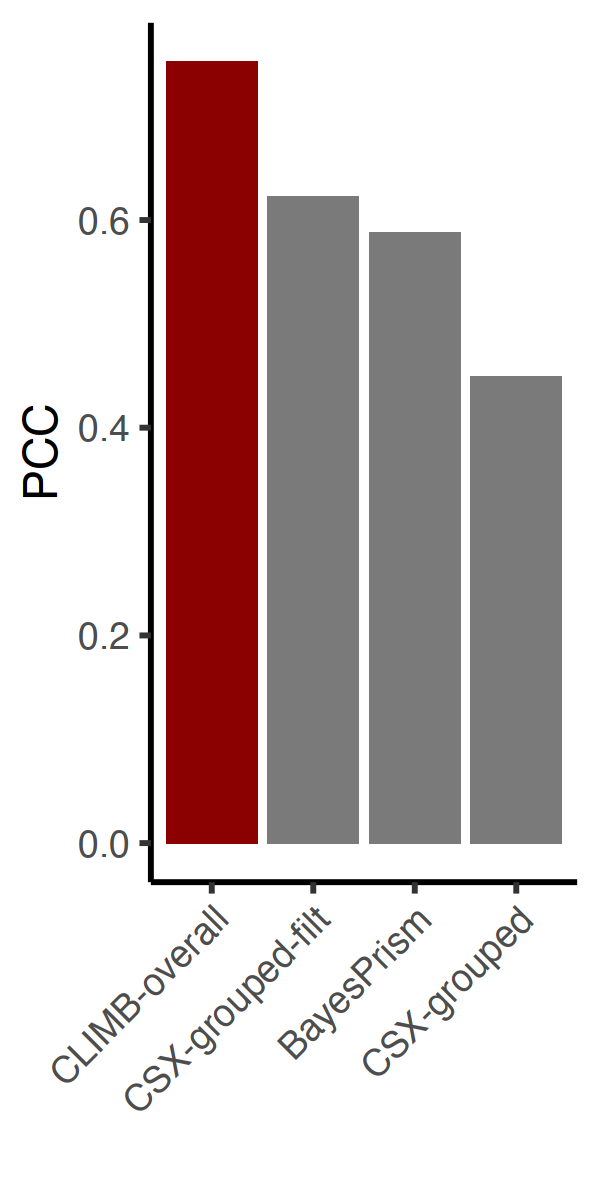

In [133]:
# Plot showing PCC
options(repr.plot.width=2, repr.plot.height=4)
ggplot(df_vg2na_metrics, aes(x=method, y=PCC, fill=method)) + geom_col() + theme_classic() +
    theme(axis.text.x = element_text(angle = 45, hjust=1.0, vjust=1.0)) + xlab('') + 
    scale_fill_manual(values = ifelse(grepl('CLIMB', levels(df_vg2na_metrics$method)), 'darkred', 'grey48'), guide='none')

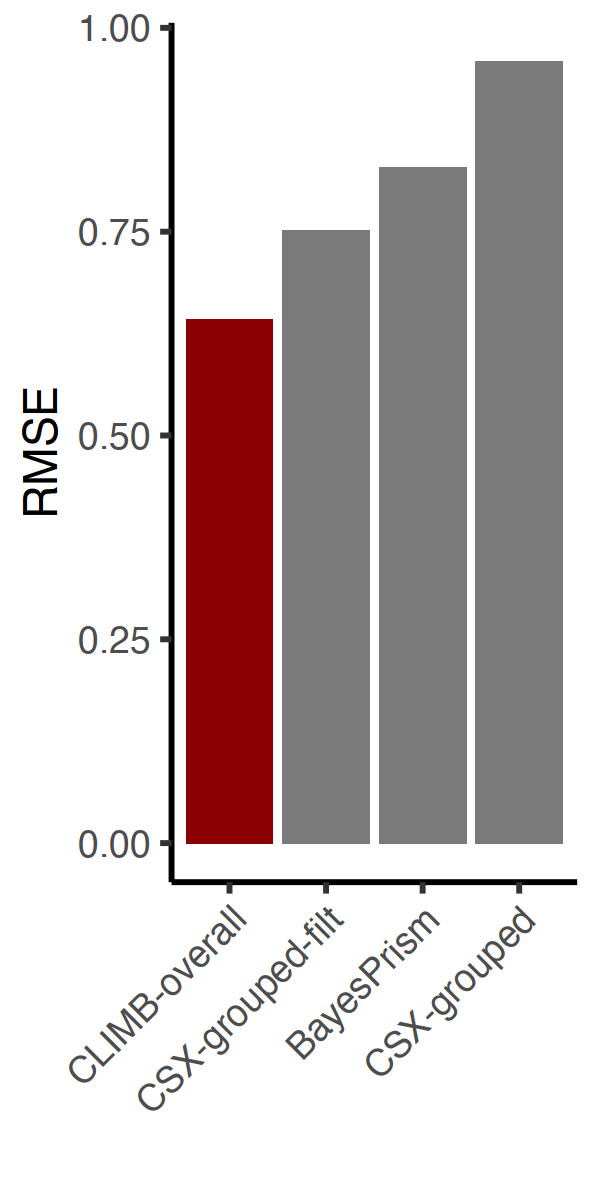

In [134]:
# Plot showing RMSE
df_vg2na_metrics$method = factor(df_vg2na_metrics$method,
                                 levels = df_vg2na_metrics$method[order(df_vg2na_metrics$RMSE)] )
options(repr.plot.width=2, repr.plot.height=4)
ggplot(df_vg2na_metrics, aes(x=method, y=RMSE, fill=method)) + geom_col() + theme_classic() +
    theme(axis.text.x = element_text(angle = 45, hjust=1.0, vjust=1.0)) + xlab('') + 
    scale_fill_manual(values = ifelse(grepl('CLIMB', levels(df_vg2na_metrics$method)), 'darkred', 'grey48'), guide='none')

# Expression Deconvolution with over-expressed genes

We will induce over-expression of 20 genes in half of the samples from Naldini datasets and make pseudo-bulks with Naldini's samples. Six samples are used to make pseudo-bulk without any gene over-expression ('WT samples'), and 7 samples with an over-expression of 20 genes in HSC-like cell-type ('OE samples'). We then use CLIMB with Van Galen et al. scRNA-seq dataset as a reference to deconvolute the expression of these pseudo-bulks. We are interested by the accuracy of the deconvoluted expression in the 20 genes over-expressed ('OE genes') and in the non-overexpressed genes ('non-OE genes'). 

Hereafter, we will produce the pseudo-bulk samples from Naldini's single-cell expression. In 7 out of the 13 samples, we induce a $10^3$ fold over-expression.

In [135]:
# We over-express genes that are part of the HSC-like signature defined by Van Galen et al.
vangalen_signature = read.csv('data/aml_3cohorts/cancer_cell_type_signature.csv')
# We filter the one found in our data
hsclike_genes = vangalen_signature$HSC.like[vangalen_signature$HSC.like %in% sel.genes]
# We select 20 of them
set.seed(1)
gene_to_induce = sample(hsclike_genes, 20)
gene_to_induce

[1] "MEIS1"     "NPTX2"     "GNG11"     "NRIP1"     "ABCA9"     "MEF2C"    
 [7] "NPDC1"     "TMEM74"    "ZPBP"      "ST3GAL1"   "HIST1H2BK" "DST"      
[13] "XIRP2"     "SPON1"     "HOPX"      "CRHBP"     "TSC22D1"   "TPSB2"    
[19] "CALCRL"    "MECOM"

We will first perform the analysis with a fold change of 10 for the over-expression. We then repeat the analysis with varying fold changes. Hereafter, we use Naldini's single-cell dataset as a template to generate pseudo-bulks, as previously achieved, but with an over-expression of the 20 genes shown above in a specific cell subtype of interest: HSC-like. Then, cell subtype expression is assembled as the bulk level into pseudo-bulk samples. 

In [136]:
FOLD_CHANGE = 10
naldini.samples = unique(sc.es.na$SubjectName)
sample_to_induce = naldini.samples[7:13]
N = length(naldini.samples) ; G = dim(sc.es.na)[1]
K = length(levels(sc.es.na$cellType))
S_true_NA = array(rep(0,N*G*K), c(N,G,K))
bulk_expr_oe_l = list() ; bulk_expr_wt_l = list()
for(n in 1:length(naldini.samples)){
    this_sample = naldini.samples[n]
    sc.es.na.sub = sc.es.na[,sc.es.na$SubjectName == this_sample]
    sc_mat = exprs(sc.es.na.sub)
    if(this_sample %in% sample_to_induce){
        sc_mat[gene_to_induce,sc.es.na.sub$cellType == 'HSClike'] = (sc_mat[gene_to_induce,sc.es.na.sub$cellType == 'HSClike']+1)*FOLD_CHANGE
    }
    ct_expr.agg = aggregate(t(exprs(sc_mat)), list(sc.es.na.sub$cellType), sum, drop=FALSE)
    rownames(ct_expr.agg) = ct_expr.agg$`Group.1`
    ct_expr.agg = ct_expr.agg[,-1]
    ct_expr.agg[is.na(ct_expr.agg)] = 0
    S_true_NA[n,,] = t(ct_expr.agg)
    bulk_expr_oe_l[[n]] = rowSums(t(ct_expr.agg))
    bulk_expr_wt_l[[n]] = rowSums(exprs(sc.es.na.sub))
}

In [137]:
# we recover bulk expression bulk_expr_oe. 
# we also recover bulk_expr_wt so we can compare the bulk expression with/without over-expression
bulk_expr_oe = t(do.call(rbind, bulk_expr_oe_l))
bulk_expr_wt = t(do.call(rbind, bulk_expr_wt_l))
# S_true_NA is the true cell-type expression in each bulk, with shape (N*G*K), N samples, G genes, K cell types
dimnames(S_true_NA) = list(naldini.samples, rownames(sc.es.na), levels(sc.es.na$cellType))

In [138]:
# We compare the over-expression at bulk level with the basal expression from Naldini's data
df_oe_vs_wt_bulk = data.frame(WT=rowMeans(bulk_expr_wt),OE=rowMeans(bulk_expr_oe))
df_oe_vs_wt_bulk$Gene = 'non-OE'
df_oe_vs_wt_bulk[rownames(df_oe_vs_wt_bulk) %in% gene_to_induce,]$Gene <- 'OE'
df_all_bulk = melt(df_oe_vs_wt_bulk)
df_all_bulk = df_all_bulk[df_all_bulk$Gene == 'OE',]
df_all_bulk = df_all_bulk[,c(2,3)]
df_all_bulk$group = 'OE genes (Bulk)'
df_all_bulk$value = log2(df_all_bulk$value+1)

Using Gene as id variables



In [139]:
# Observed Fold Change
(mean(S_true_NA[7:13,gene_to_induce,4])+1) / (mean(flatten(S_true_NA[1:6,gene_to_induce,4]))+1)

[1] 7.024489

we see that the over-expression with fold change 10 at the single-cell levels leads to an average slightly lower at cell subtype level.

In [140]:
# Next, we compute the difference in true expression between WT and OE samples in HSC-like for our OE genes
df_expr_OEgenes = data.frame(WT=colMeans(log2(S_true_NA[1:6,gene_to_induce,4]+1)), 
                             OE=colMeans(log2(S_true_NA[7:13,gene_to_induce,4]+1)))
melt_df_expr_OEgenes = melt(df_expr_OEgenes)
melt_df_expr_OEgenes$group = 'OE genes (HSC-like)'

df_expr_ALLgenes = data.frame(WT=apply(log2(S_true_NA[1:6,!rownames(sc.es.na) %in% gene_to_induce,-4]+1), 2, mean), 
                              OE=apply(log2(S_true_NA[7:13,!rownames(sc.es.na) %in% gene_to_induce,-4]+1), 2, mean))
melt_df_expr_ALLgenes = melt(df_expr_ALLgenes)
melt_df_expr_ALLgenes$group = 'Other genes'

# We assemble in one data.frame to show the fold change in our over-expression genes, 
# at cell-type and bulk level
df_all = rbind(melt_df_expr_OEgenes, melt_df_expr_ALLgenes, df_all_bulk)
df_all$`Sample Group` = gsub('OE', 'OE samples', gsub('WT', 'WT samples', df_all$variable))

No id variables; using all as measure variables

No id variables; using all as measure variables



Hereafter, we show the amplitude of over-expression we have induced, at the bulk level and at the cell subtype level in HSC-like cells. 

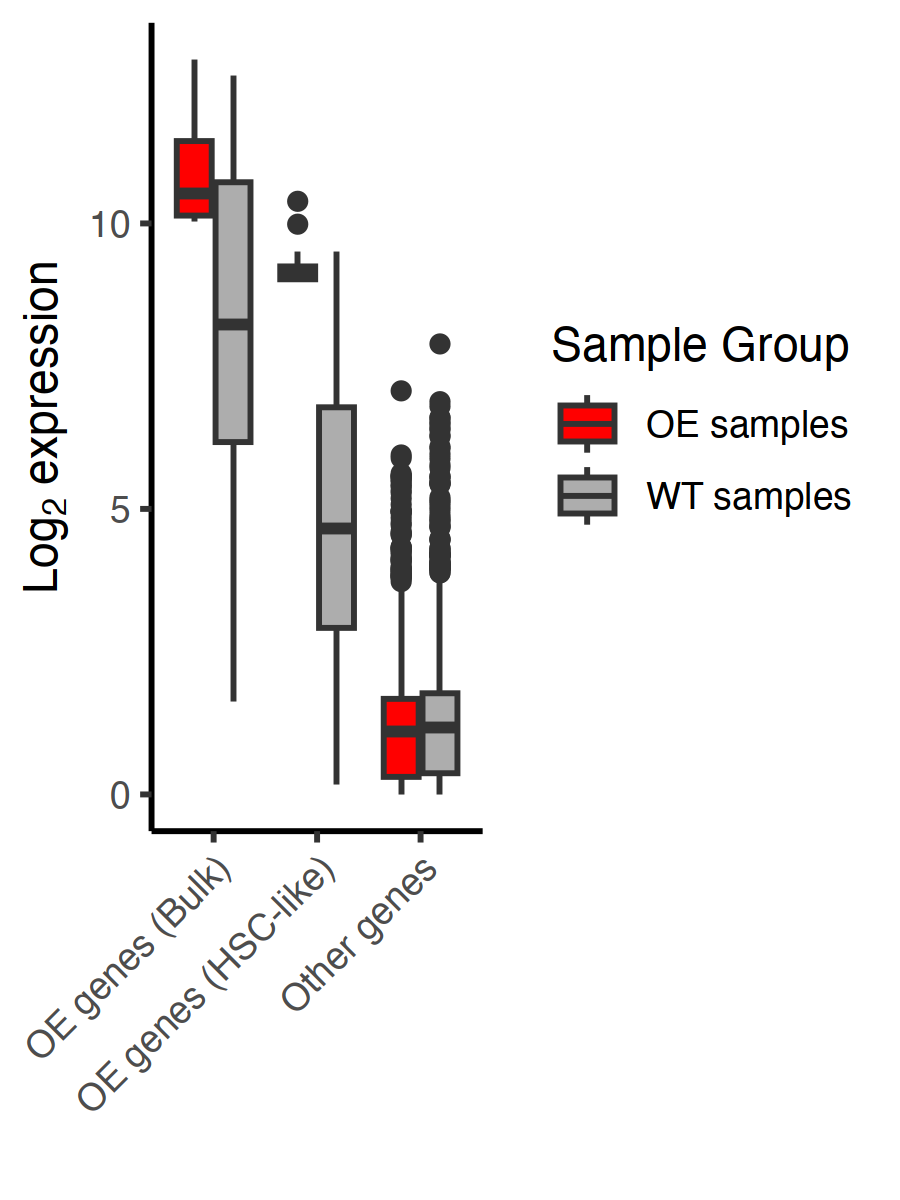

In [145]:
options(repr.plot.width=3, repr.plot.height=4)
ggplot(df_all) + geom_boxplot(aes(x=group, y=value, fill = `Sample Group`)) +
    scale_fill_manual(values = c('red', 'grey68')) + theme_classic() + 
    theme(axis.text.x = element_text(angle = 45, hjust=1.0, vjust=1.0)) +
    ylab(expression(paste(Log[2], ' expression')))+ xlab('')

In [146]:
# Save ExpressionSet object containing bulk expression with OE genes, and true expression, in RDS objects
# saveRDS(bulk.es.na.overexpression, 'data/expression_deconv/AML_naldini_pbulks_vg_labs_es_OE_n7to13_fc2.RDS')
# saveRDS(S_true_NA, 'data/expression_deconv/AML_naldini_TRUE_EXPR_OE_n7to13_fc2.RDS')

### Launch DE analysis on true expression to define true DEGs 

In [147]:
# bulk.es.na.overexpression =  readRDS("data/pseudobulks_climb/AML_naldini_pbulks_vg_labs.RDS")
true_prop = pData(bulk.es.na.overexpression)
colnames(true_prop) = reformat_celltypes(colnames(true_prop))
true_prop = true_prop[dimnames(S_true_NA)[[1]], dimnames(S_true_NA)[[3]]]
bulk.es.na.overexpression = bulk.es.na.overexpression[dimnames(S_true_NA)[[2]], dimnames(S_true_NA)[[1]]]
all(rownames(bulk.es.na.overexpression) == rownames(bulk_expr_oe))
# Add the expression with OE genes in the ExpressionSet object
exprs(bulk.es.na.overexpression) = bulk_expr_oe

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'object' in selecting a method for function 'pData': object 'bulk.es.na.overexpression' not found


In [1110]:
S_true_NA = readRDS('data/expression_deconv/AML_naldini_TRUE_EXPR_OE_n7to13_fc2.RDS')

In [1111]:
S_mat = S_true_NA

In [1112]:
# Make a list of genes for CiberSortX high-resolution mode
set.seed(10)
random_sel = sample(dimnames(S_true_NA)[[2]][!dimnames(S_true_NA)[[2]] %in% gene_to_induce], 20)
gene_sel = c(gene_to_induce, random_sel)
# We load signature genes from Van Galen et al. and we add the 40 genes used in previous analysis
vangalen_signature = read.csv('data/aml_3cohorts/cancer_cell_type_signature.csv')
cancer_celltype_markers_all = flatten(vangalen_signature)
cancer_celltype_markers_all = unique(c(cancer_celltype_markers_all, gene_sel))
all(gene_sel %in% cancer_celltype_markers_all)
cancer_celltype_markers_all = cancer_celltype_markers_all[cancer_celltype_markers_all %in% dimnames(S_mat)[[2]]]

[1] TRUE

In [1114]:
S_mat = S_mat[,,grepl('like',dimnames(S_mat)[[3]])]
K = dim(S_mat)[3]
library(DESeq2)
fcs_ = matrix(0, nrow=dim(S_mat)[2], ncol=dim(S_mat)[3])
pvals_ = matrix(0, nrow=dim(S_mat)[2], ncol=dim(S_mat)[3])
padjs_ = matrix(0, nrow=dim(S_mat)[2], ncol=dim(S_mat)[3])
conditions = c(rep('WT', 6), rep('OE', 7))
for (k in 1:K) {
    S_k = S_mat[, , k]
    if (rankMatrix(S_k)[1] == 0) {
      if (verbose) {
        message("matrix not full ranked, skipping cell-type")
      }
      next
    }
    colData = data.frame(condition = conditions, tot_expr = rowSums(S_k))
    dds <- DESeqDataSetFromMatrix(countData = t(S_k) + 
      1, colData = colData, design = (~tot_expr + condition))
    dds <- tryCatch(expr = {
      DESeq(dds)
    }, error = function(cond) {
      if (verbose) {
        message("Error with DE analysis, using fit with mean instead")
      }
      return(DESeq(dds, fitType = "mean"))
    })
    fcs_[, k] = num(-1 * results(dds, tidy = TRUE)$log2FoldChange)
    pvals_[, k] = num(results(dds, tidy = TRUE)$pvalue)
    padjs_[, k] = num(results(dds, tidy = TRUE)$padj)
}

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

converting counts to integer mode

Warning mess

In [1117]:
padjs = data.frame(padjs_)
colnames(padjs) = dimnames(S_mat)[[3]]
rownames(padjs) = dimnames(S_mat)[[2]]
padjs = -log10(padjs)
padjs[is.na(padjs)] <- 0
fcs = data.frame(fcs_)
colnames(fcs) = dimnames(S_mat)[[3]]
rownames(fcs) = dimnames(S_mat)[[2]]
fcs[is.na(fcs)] <- 0.0
padjs$gene_name = rownames(padjs)
padjs_melt = melt(padjs)
colnames(padjs_melt) = c('gene', 'celltype', 'log_padj')
fcs$gene_name = rownames(fcs)
fcs_melt = melt(fcs)
padjs_melt$fc = fcs_melt$value
padjs_melt$type.true = 0
padjs_melt[padjs_melt$gene %in% gene_to_induce & padjs_melt$celltype == 'HSClike',]$type.true <- 1

Using gene_name as id variables

Using gene_name as id variables



In [1119]:
library(precrec)
roc_score = evalmod(scores = padjs_melt$log_padj, labels = padjs_melt$type.true, mode = "aucroc")
auc_true = roc_score$uaucs$aucs
auc_true

[1] 0.9973616

### Launch CLIMB deconvolution in high-resolution mode

In [1120]:
bulk.es.na.overexpression = readRDS('data/expression_deconv/AML_naldini_pbulks_vg_labs_es_OE_n7to13_fc2.RDS')

In [1121]:
# Uncomment and launch following to launch CLIMB deconvolution in expression mode 
# Alternatively, jump to next cell to load processed results
climb_out = climb(sc.es.vg, bulk.es.na.overexpression, mode='expression', cancer_pattern = 'like')
# Save CLIMB output object
saveRDS(climb_out, 'data/expression_deconv/climb_out_vg2na_OE_n7to13_fc2.RDS')

EXPRESSION mode: predicting cell-type expression in bulks - requires single-cell coefficients fitted by CLIMB

5368 common genes found between scRNA-seq refererence and bulk datasets

Bulk to single-cell mapping for prediction of cell-type abundance / expression

Cell-type abundance prediction done. 

Starting high-resolution expression deconvolution

High-Resolution expression prediction: 1000 genes processed...

High-Resolution expression prediction: 2000 genes processed...

High-Resolution expression prediction: 3000 genes processed...

High-Resolution expression prediction: 4000 genes processed...

High-Resolution expression prediction: 5000 genes processed...



In [1764]:
climb_out = readRDS('data/expression_deconv/climb_out_vg2na_OE_n7to13_fc2.RDS')

In [1765]:
S_true_NA = readRDS('data/expression_deconv/AML_naldini_TRUE_EXPR_OE_n7to13_fc2.RDS')

In [1766]:
climb_expr = climb_out$expr.highres
climb_expr = climb_expr[,,dimnames(climb_expr)[[3]] %in% dimnames(S_true_NA)[[3]]]

### Look at predicted expression of over-expressed genes

In [1767]:
set.seed(10)
random_sel = sample(dimnames(climb_expr)[[2]][!dimnames(climb_expr)[[2]] %in% gene_to_induce], 20)
gene_sel = c(gene_to_induce, random_sel)
groups_gene = c(rep('OE genes', 20), rep('Non-OE genes', 20))

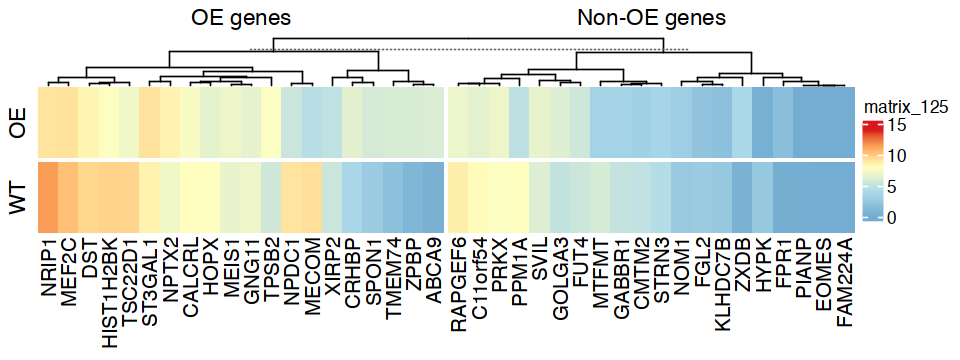

In [1768]:
col_panel = c('#74add1', "#abd9e9", '#ffffbf','#fdae61', '#d7191c')
col_fun = colorRamp2(c(0,4,8,11,14), col_panel)

options(repr.plot.width=8, repr.plot.height=3)
h <- Heatmap(rbind(colMeans(log2(climb_expr[1:6,gene_sel,'HSClike']+1)),
              colMeans(log2(climb_expr[7:13,gene_sel,'HSClike']+1))),
        row_split = c('WT','OE'), column_split = groups_gene,  cluster_rows = F, col=col_fun)
#pdf('results/fig4/heatmap_celltype_expr_CLIMB_HSClike_avgGroups_fc2.pdf', width=8, height=3) ; h ; dev.off()
h

In [1771]:
col_panel = c('#74add1', "#abd9e9", '#ffffbf','#fdae61', '#d7191c')
col_fun = colorRamp2(c(0,3,6,9,12), col_panel)

pdf 
  2

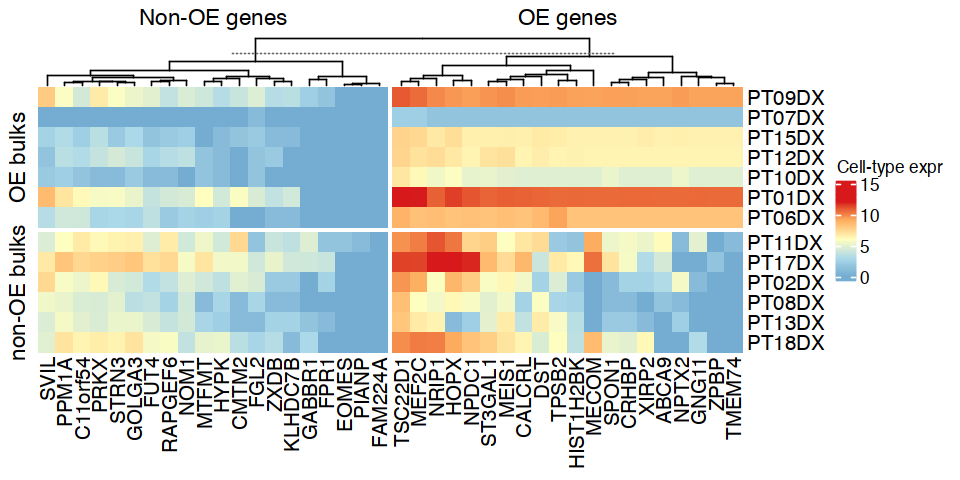

In [1775]:
options(repr.plot.width=8, repr.plot.height=4)
h <- Heatmap(log2(S_true_NA[,gene_sel,'HSClike']+1), 
        row_split = c(rep('non-OE bulks',6), rep('OE bulks', 7)), column_split = groups_gene,
        cluster_rows = F, col=col_fun, name='Cell-type expr')
pdf('results/fig4/heatmap_celltype_expr_TRUE_HSClike_fc2.pdf', width=8, height=4) ; h ; dev.off()
h <- draw(h)

In [1773]:
row_h = row_order(h) ; col_h = column_order(h)
row_h = c(row_h$`non-OE bulks`, row_h$`OE bulks`)
col_h = c(col_h$`OE genes`, col_h$`Non-OE genes`)

pdf 
  2

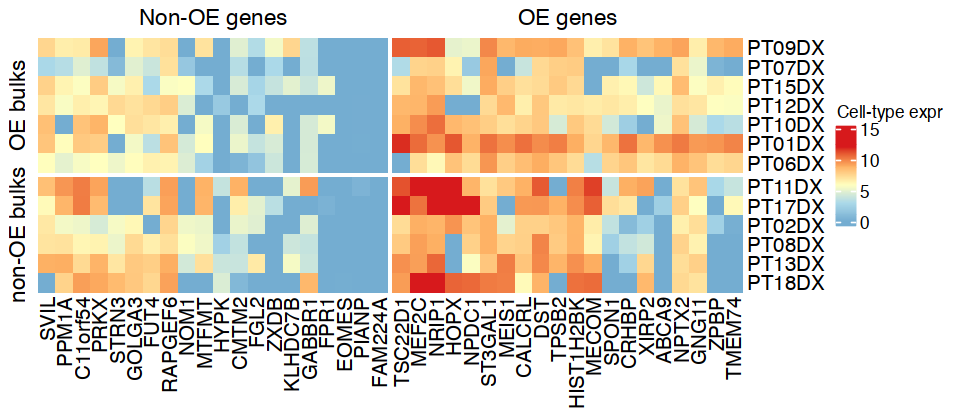

In [1774]:
options(repr.plot.width=8, repr.plot.height=3.5)
h <- Heatmap(log2(climb_expr[,gene_sel,'HSClike']+1)[row_h, col_h], 
        row_split = c(rep('non-OE bulks',6), rep('OE bulks', 7)), column_split = groups_gene,
        cluster_rows = F, cluster_columns=F, col=col_fun, name='Cell-type expr')
pdf('results/fig4/heatmap_celltype_expr_CLIMB_HSClike_fc2.pdf', width=8, height=3.5) ; h ; dev.off()
h <- draw(h)

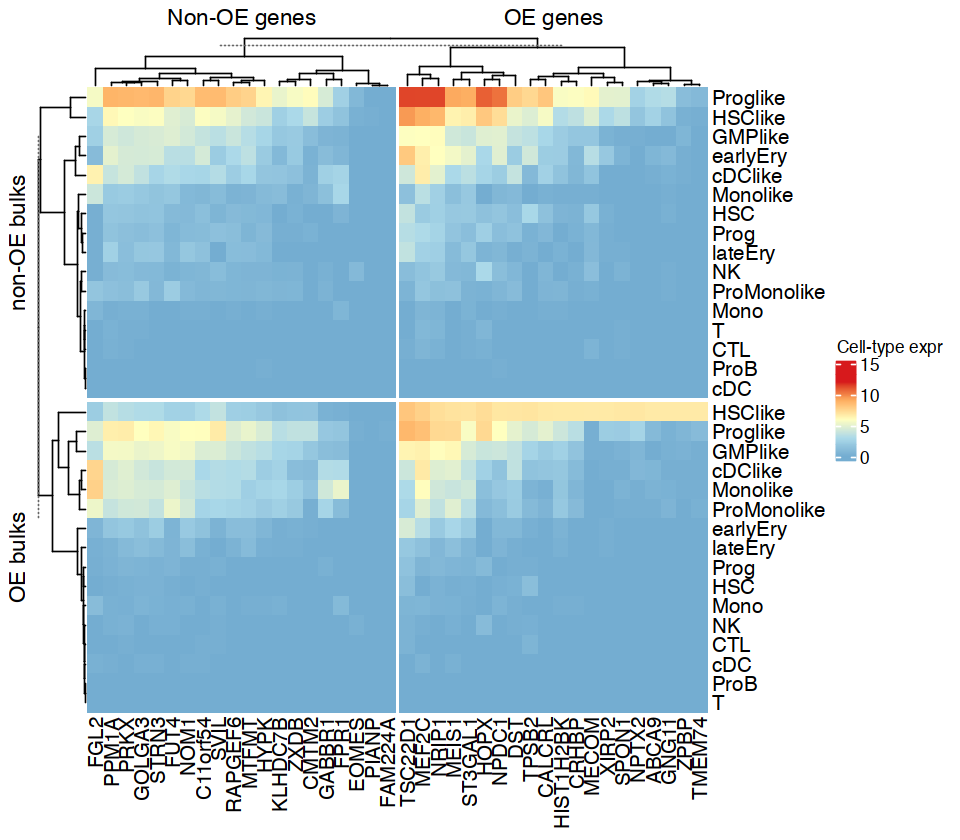

In [1309]:
col_panel = c('#74add1', "#abd9e9", '#ffffbf','#fdae61', '#d7191c')
col_fun = colorRamp2(c(0,3,6,9,12), col_panel)
### Plot TRUE cell-type expression average per groups (OE and WT) in each cell-types
celltype_avg_oe_l = list() ; celltype_avg_wt_l = list()
for(k in 1:length(dimnames(S_true_NA)[[3]])){
    this_celltype = dimnames(S_true_NA)[[3]][k]
    celltype_avg_wt_l[[k]] = colMeans(log2(S_true_NA[1:6,gene_sel,this_celltype]+1))
    celltype_avg_oe_l[[k]] = colMeans(log2(S_true_NA[7:13,gene_sel,this_celltype]+1))
}
cell_avg_oe.true = do.call(rbind, celltype_avg_oe_l)
cell_avg_wt.true = do.call(rbind, celltype_avg_wt_l)
celltype_avg.true = rbind(cell_avg_oe.true, cell_avg_wt.true)
rownames(celltype_avg.true) = rep(dimnames(climb_expr)[[3]], 2)
options(repr.plot.width=8, repr.plot.height=7)
h <- Heatmap(celltype_avg.true, row_split = c(rep('OE bulks',16), rep('non-OE bulks', 16)), column_split = groups_gene,
        col=col_fun, name='Cell-type expr')
#pdf('results/fig4/heatmap_celltype_expr_true_avg_per_ct_fc2.pdf', width=8.5, height=6.8) ; h ; dev.off()
h <- draw(h)

In [1310]:
row_h = row_order(h) ; col_h = column_order(h)
row_h = c(row_h$`non-OE bulks`, row_h$`OE bulks`)
col_h = c(col_h$`OE genes`, col_h$`Non-OE genes`)

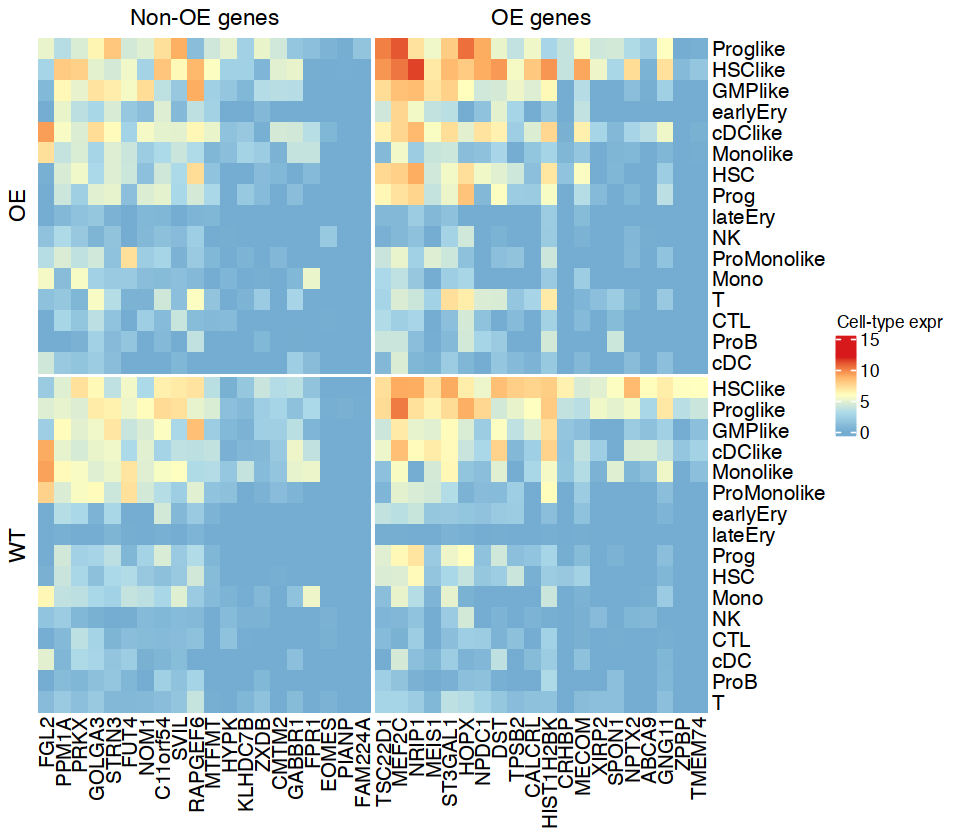

In [1311]:
### Plot CLIMB cell-type expression average per groups (OE and WT) in each cell-types
celltype_avg_oe_l = list() ; celltype_avg_wt_l = list()
for(k in 1:length(dimnames(climb_expr)[[3]])){
    this_celltype = dimnames(climb_expr)[[3]][k]
    celltype_avg_wt_l[[k]] = colMeans(log2(climb_expr[1:6,gene_sel,this_celltype]+1))
    celltype_avg_oe_l[[k]] = colMeans(log2(climb_expr[7:13,gene_sel,this_celltype]+1))
}
cell_avg_oe = do.call(rbind, celltype_avg_oe_l)
cell_avg_wt = do.call(rbind, celltype_avg_wt_l)
celltype_avg = rbind(cell_avg_oe, cell_avg_wt)
rownames(celltype_avg) = rep(dimnames(climb_expr)[[3]], 2)
options(repr.plot.width=8, repr.plot.height=7)
h <- Heatmap(celltype_avg[row_h, col_h], row_split = c(rep('OE',16), rep('WT', 16)), column_split = groups_gene,
        col=col_fun, name='Cell-type expr', cluster_rows=F, cluster_columns=F)
#pdf('results/fig4/heatmap_celltype_expr_CLIMB_avg_per_ct_fc2.pdf', width=8.5, height=6.8) ; h ; dev.off()
h

In [1312]:
# Make a list of genes for CiberSortX high-resolution mode
set.seed(10)
random_sel = sample(dimnames(climb_expr)[[2]][!dimnames(climb_expr)[[2]] %in% gene_to_induce], 20)
gene_sel = c(gene_to_induce, random_sel)
# We load signature genes from Van Galen et al. and we add the 40 genes used in previous analysis
vangalen_signature = read.csv('data/aml_3cohorts/cancer_cell_type_signature.csv')
cancer_celltype_markers_all = flatten(vangalen_signature)
cancer_celltype_markers_all = unique(c(cancer_celltype_markers_all, gene_sel))
length(cancer_celltype_markers_all)

[1] 317

In [1313]:
gene_selection = cancer_celltype_markers_all[cancer_celltype_markers_all %in% dimnames(climb_expr)[[2]]]

In [1315]:
climb_expr.sub = climb_expr[,gene_selection,grepl('like',dimnames(climb_expr)[[3]])]
S_true_NA.sub = S_true_NA[,gene_selection,grepl('like',dimnames(S_true_NA)[[3]])]

In [1316]:
all(dimnames(climb_expr.sub)[[1]] == dimnames(S_true_NA.sub)[[1]]) &
all(dimnames(climb_expr.sub)[[2]] == dimnames(S_true_NA.sub)[[2]]) &
all(dimnames(climb_expr.sub)[[3]] == dimnames(S_true_NA.sub)[[3]])

[1] TRUE

In [1317]:
cor(flatten(climb_expr.sub), flatten(S_true_NA.sub))

[1] 0.6815947

### DE analysis from CLIMB to compute accuracy to detect DEGs 

In [1133]:
climb_out = readRDS('data/expression_deconv/climb_out_vg2na_OE_n7to13_fc2.RDS')

In [1134]:
S_mat = climb_out$expr.highres

In [1135]:
# Make a list of genes for CiberSortX high-resolution mode
set.seed(10)
random_sel = sample(dimnames(S_mat)[[2]][!dimnames(S_mat)[[2]] %in% gene_to_induce], 20)
gene_sel = c(gene_to_induce, random_sel)
# We load signature genes from Van Galen et al. and we add the 40 genes used in previous analysis
vangalen_signature = read.csv('data/aml_3cohorts/cancer_cell_type_signature.csv')
cancer_celltype_markers_all = flatten(vangalen_signature)
cancer_celltype_markers_all = unique(c(cancer_celltype_markers_all, gene_sel))
all(gene_sel %in% cancer_celltype_markers_all)
cancer_celltype_markers_all = cancer_celltype_markers_all[cancer_celltype_markers_all %in% dimnames(S_mat)[[2]]]

[1] TRUE

In [1136]:
S_mat <- round(S_mat)
S_mat = S_mat[,,grepl('like',dimnames(S_mat)[[3]])]
library(DESeq2)
fcs_ = matrix(0, nrow=dim(S_mat)[2], ncol=dim(S_mat)[3])
pvals_ = matrix(0, nrow=dim(S_mat)[2], ncol=dim(S_mat)[3])
padjs_ = matrix(0, nrow=dim(S_mat)[2], ncol=dim(S_mat)[3])
conditions = c(rep('WT', 6), rep('OE', 7))
for (k in 1:K) {
    S_k = S_mat[, , k]
    if (rankMatrix(S_k)[1] == 0) {
      if (verbose) {
        message("matrix not full ranked, skipping cell-type")
      }
      next
    }
    colData = data.frame(condition = conditions, tot_expr = rowSums(S_k))
    dds <- DESeqDataSetFromMatrix(countData = t(S_k) + 
      1, colData = colData, design = (~tot_expr + condition))
    dds <- tryCatch(expr = {
      DESeq(dds)
    }, error = function(cond) {
      if (verbose) {
        message("Error with DE analysis, using fit with mean instead")
      }
      return(DESeq(dds, fitType = "mean"))
    })
    fcs_[, k] = num(-1 * results(dds, tidy = TRUE)$log2FoldChange)
    pvals_[, k] = num(results(dds, tidy = TRUE)$pvalue)
    padjs_[, k] = num(results(dds, tidy = TRUE)$padj)
}

In [1138]:
padjs = data.frame(padjs_)
colnames(padjs) = dimnames(S_mat)[[3]]
rownames(padjs) = dimnames(S_mat)[[2]]
padjs = -log10(padjs)
padjs[is.na(padjs)] <- 0
fcs = data.frame(fcs_)
colnames(fcs) = dimnames(S_mat)[[3]]
rownames(fcs) = dimnames(S_mat)[[2]]
fcs[is.na(fcs)] <- 0.0
padjs$gene_name = rownames(padjs)
padjs_melt = melt(padjs)
colnames(padjs_melt) = c('gene', 'celltype', 'log_padj')
fcs$gene_name = rownames(fcs)
fcs_melt = melt(fcs)
padjs_melt$fc = fcs_melt$value
padjs_melt$type.true = 0
padjs_melt[padjs_melt$gene %in% gene_to_induce & padjs_melt$celltype == 'HSClike',]$type.true <- 1

Using gene_name as id variables

Using gene_name as id variables



In [1142]:
padjs_melt_ = padjs_melt[padjs_melt$gene %in% cancer_celltype_markers_all,]

In [1143]:
library(precrec)
roc_score = evalmod(scores = padjs_melt_$log_padj, labels = padjs_melt_$type.true, mode = "aucroc")
auc_true = roc_score$uaucs$aucs
auc_true

[1] 0.5917879

## Launch analysis of DEGs detection accuracy for all fold changes at once

In [1776]:
library(DESeq2) ; library(precrec)
fold_changes = c('fc2', 'fc5', 'fc10', 'fc100', 'fc1000')
highres_cor_climb = list()
highres_auc_celltype_climb = list()
highres_auc_pergene_climb = list()
for(i in 1:length(fold_changes)){
    fc = fold_changes[i]
    s_true_file = paste0('data/expression_deconv/AML_naldini_TRUE_EXPR_OE_n7to13_',fc,'.RDS')
    S_true_NA = readRDS(s_true_file)
    climb_out_file = paste0('data/expression_deconv/climb_out_vg2na_OE_n7to13_',fc,'.RDS')
    climb_out = readRDS(climb_out_file)
    climb_expr = climb_out$expr.highres
    climb_expr.sub = climb_expr[,gene_selection,grepl('like',dimnames(climb_expr)[[3]])]
    S_true_NA.sub = S_true_NA[,gene_selection,grepl('like',dimnames(S_true_NA)[[3]])]
    highres_cor_climb[[i]] = cor(flatten(climb_expr.sub), flatten(S_true_NA.sub))
    # compute AUC to detect DEGs
    S_mat <- round(climb_expr.sub)
    fcs_ = matrix(0, nrow=dim(S_mat)[2], ncol=dim(S_mat)[3])
    pvals_ = matrix(0, nrow=dim(S_mat)[2], ncol=dim(S_mat)[3])
    padjs_ = matrix(0, nrow=dim(S_mat)[2], ncol=dim(S_mat)[3])
    conditions = c(rep('WT', 6), rep('OE', 7))
    for (k in 1:6) {
        S_k = S_mat[, , k]
        if (rankMatrix(S_k)[1] == 0) {
          if (verbose) {
            message("matrix not full ranked, skipping cell-type")
          }
          next
        }
        colData = data.frame(condition = conditions, tot_expr = rowSums(S_k))
        dds <- DESeqDataSetFromMatrix(countData = t(S_k) + 
          1, colData = colData, design = (~tot_expr + condition))
        dds <- tryCatch(expr = {
          DESeq(dds)
        }, error = function(cond) {
          if (verbose) {
            message("Error with DE analysis, using fit with mean instead")
          }
          return(DESeq(dds, fitType = "mean"))
        })
        fcs_[, k] = num(-1 * results(dds, tidy = TRUE)$log2FoldChange)
        pvals_[, k] = num(results(dds, tidy = TRUE)$pvalue)
        padjs_[, k] = num(results(dds, tidy = TRUE)$padj)
    }
    padjs = data.frame(padjs_)
    colnames(padjs) = dimnames(S_mat)[[3]]
    rownames(padjs) = dimnames(S_mat)[[2]]
    padjs = -log10(padjs)
    padjs[is.na(padjs)] <- 0
    fcs = data.frame(fcs_)
    colnames(fcs) = dimnames(S_mat)[[3]]
    rownames(fcs) = dimnames(S_mat)[[2]]
    fcs[is.na(fcs)] <- 0.0
    padjs$gene_name = rownames(padjs)
    padjs_melt = melt(padjs)
    colnames(padjs_melt) = c('gene', 'celltype', 'log_padj')
    fcs$gene_name = rownames(fcs)
    fcs_melt = melt(fcs)
    padjs_melt$fc = fcs_melt$value
    padjs_melt$type.true = 0
    padjs_melt$score = padjs_melt$log_padj * padjs_melt$fc
    padjs_melt[padjs_melt$gene %in% gene_to_induce & padjs_melt$celltype == 'HSClike',]$type.true <- 1
    padjs_melt.hsclike = padjs_melt[padjs_melt$celltype == 'HSClike',]
    # AUC for detecting DEGs among all genes in HSClike
    padjs_melt_ = padjs_melt.hsclike[padjs_melt.hsclike$gene %in% cancer_celltype_markers_all,]
    roc_score = evalmod(scores = padjs_melt_$score, labels = padjs_melt_$type.true, mode = "aucroc")
    highres_auc_celltype_climb[[i]] = roc_score$uaucs$aucs
    # AUC for detecting DEGs in correct cell-type for each DEG
    highres_auc_1gene = list()
    for(g in 1:length(gene_to_induce)){
        gene = gene_to_induce[g]
        padjs_melt.1gene = padjs_melt[padjs_melt$gene == gene,]
        roc_score = evalmod(scores = padjs_melt.1gene$score, labels = padjs_melt.1gene$type.true, mode = "aucroc")
        highres_auc_1gene[[g]] = roc_score$uaucs$aucs
    }
    highres_auc_pergene_climb[[i]] = mean(num(highres_auc_1gene)) # average over 20 genes
}

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = 

final dispersion estimates

fitting model and testing

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersi

fitting model and testing

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

converting counts to

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = 

final dispersion estimates

fitting model and testing

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersi

## Positive / Negative control : perform detection of DEGs with true expression , and with randomly shuffled expression

In [1784]:
library(DESeq2) ; library(precrec)
fold_changes = c('fc2', 'fc5', 'fc10', 'fc100', 'fc1000')
highres_auc_celltype_true = list()
highres_auc_pergene_true = list()
highres_auc_celltype_random = list()
highres_auc_pergene_random = list()
for(i in 1:length(fold_changes)){
    fc = fold_changes[i]
    s_true_file = paste0('data/expression_deconv/AML_naldini_TRUE_EXPR_OE_n7to13_',fc,'.RDS')
    S_true_NA = readRDS(s_true_file)
    S_true_NA.sub = S_true_NA[,gene_selection,grepl('like',dimnames(S_true_NA)[[3]])]
    # compute AUC to detect DEGs
    S_mat <- round(S_true_NA.sub)
    fcs_ = matrix(0, nrow=dim(S_mat)[2], ncol=dim(S_mat)[3])
    pvals_ = matrix(0, nrow=dim(S_mat)[2], ncol=dim(S_mat)[3])
    padjs_ = matrix(0, nrow=dim(S_mat)[2], ncol=dim(S_mat)[3])
    conditions = c(rep('WT', 6), rep('OE', 7))
    for (k in 1:6) {
        S_k = S_mat[, , k]
        if (rankMatrix(S_k)[1] == 0) {
          if (verbose) {
            message("matrix not full ranked, skipping cell-type")
          }
          next
        }
        colData = data.frame(condition = conditions, tot_expr = rowSums(S_k))
        dds <- DESeqDataSetFromMatrix(countData = t(S_k) + 
          1, colData = colData, design = (~tot_expr + condition))
        dds <- tryCatch(expr = {
          DESeq(dds)
        }, error = function(cond) {
          if (verbose) {
            message("Error with DE analysis, using fit with mean instead")
          }
          return(DESeq(dds, fitType = "mean"))
        })
        fcs_[, k] = num(-1 * results(dds, tidy = TRUE)$log2FoldChange)
        pvals_[, k] = num(results(dds, tidy = TRUE)$pvalue)
        padjs_[, k] = num(results(dds, tidy = TRUE)$padj)
    }
    padjs = data.frame(padjs_)
    colnames(padjs) = dimnames(S_mat)[[3]]
    rownames(padjs) = dimnames(S_mat)[[2]]
    padjs = -log10(padjs)
    padjs[is.na(padjs)] <- 0
    fcs = data.frame(fcs_)
    colnames(fcs) = dimnames(S_mat)[[3]]
    rownames(fcs) = dimnames(S_mat)[[2]]
    fcs[is.na(fcs)] <- 0.0
    padjs$gene_name = rownames(padjs)
    padjs_melt = melt(padjs)
    colnames(padjs_melt) = c('gene', 'celltype', 'log_padj')
    fcs$gene_name = rownames(fcs)
    fcs_melt = melt(fcs)
    padjs_melt$fc = fcs_melt$value
    padjs_melt$type.true = 0
    padjs_melt$score = padjs_melt$log_padj * padjs_melt$fc
    padjs_melt[padjs_melt$gene %in% gene_to_induce & padjs_melt$celltype == 'HSClike',]$type.true <- 1
    padjs_melt.hsclike = padjs_melt[padjs_melt$celltype == 'HSClike',]

    # AUC for detecting DEGs among all genes in HSClike
    padjs_melt_ = padjs_melt.hsclike[padjs_melt.hsclike$gene %in% cancer_celltype_markers_all,]
    roc_score = evalmod(scores = padjs_melt_$score, labels = padjs_melt_$type.true, mode = "aucroc")
    highres_auc_celltype_true[[i]] = roc_score$uaucs$aucs
    # AUC for detecting DEGs in correct cell-type for each DEG
    highres_auc_1gene = list()
    for(g in 1:length(gene_to_induce)){
        gene = gene_to_induce[g]
        padjs_melt.1gene = padjs_melt[padjs_melt$gene == gene,]
        roc_score = evalmod(scores = padjs_melt.1gene$score, labels = padjs_melt.1gene$type.true, mode = "aucroc")
        highres_auc_1gene[[g]] = roc_score$uaucs$aucs
    }
    highres_auc_pergene_true[[i]] = mean(num(highres_auc_1gene))
    
    # Same with random rearrangements
    padjs_melt$score = sample(padjs_melt$score)
    padjs_melt.hsclike = padjs_melt[padjs_melt$celltype == 'HSClike',]
    padjs_melt_ = padjs_melt.hsclike[padjs_melt.hsclike$gene %in% cancer_celltype_markers_all,]
    roc_score = evalmod(scores = padjs_melt_$score, labels = padjs_melt_$type.true, mode = "aucroc")
    highres_auc_celltype_random[[i]] = roc_score$uaucs$aucs
    # AUC for detecting DEGs in correct cell-type for each DEG
    highres_auc_1gene = list()
    for(g in 1:length(gene_to_induce)){
        gene = gene_to_induce[g]
        padjs_melt.1gene = padjs_melt[padjs_melt$gene == gene,]
        roc_score = evalmod(scores = padjs_melt.1gene$score, labels = padjs_melt.1gene$type.true, mode = "aucroc")
        highres_auc_1gene[[g]] = roc_score$uaucs$aucs
    }
    highres_auc_pergene_random[[i]] = mean(num(highres_auc_1gene))
}

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = 

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit

  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting 

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  the design formula contains one or more numeric variables with integer v

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this 

## Launch deconvolution with BayesPrism

In [1698]:
bulk.es.na.overexpression = readRDS('data/expression_deconv/AML_naldini_pbulks_vg_labs_es_OE_n7to13_fc2.RDS')

In [1148]:
# BayesPrism
myPrism <- new.prism(reference= t(exprs(sc.es.vg)), 
                         mixture=t(exprs(bulk.es.na.overexpression)), input.type="count.matrix", 
                         cell.type.labels = as.character(sc.es.vg$cellType), 
                         cell.state.labels = as.character(sc.es.vg$cellType), 
                         key = NULL,outlier.cut=1.0, outlier.fraction=1.0) # parameters to avoid gene filtering
bp.res <- run.prism(prism = myPrism, n.cores=6)

# recover expression deconvoluted by BayesPrism:
bayesprism.exp = data.frame(get.exp(bp.res, state.or.type="state")) 
N = dim(bayesprism.exp)[1] ; G = dim(bayesprism.exp)[2]/19 ; K = 19
celltype_names = levels(factor(sc.es.vg$cellType))
### Compute Bayesprism High-Resolution Cell-type Expression
S_bayesprism_n = array(rep(0,N*G*K), c(N,G,K))
for(n in 1:N){ # careful to add samples in the right order !
    k=1
    for(i in 1:19){
        ct = celltype_names[i]
        sel.k = grepl(paste0("\\<",ct,"\\>"), colnames(bayesprism.exp))
        s_nk = bayesprism.exp[n,sel.k]
        colnames(s_nk) = gsub(paste0('\\.',ct), '', colnames(s_nk))
        S_bayesprism_n[n,,k] = num(s_nk)
        k=k+1
    }
}
bp_gene_names = unique(gsub("\\.[^\\.]+$", "",colnames(bayesprism.exp))) # reformat gene names
bp_gene_names = gsub('\\.', '-', bp_gene_names)

# attribute sample, gene, and sample names
dimnames(S_bayesprism_n)[[1]] = colnames(bulk.es.na.overexpression)
dimnames(S_bayesprism_n)[[2]] = bp_gene_names
dimnames(S_bayesprism_n)[[3]] = celltype_names

number of cells in each cell state 
cell.state.labels
       ProB     lateEry         CTL     ProMono    earlyEry      Plasma 
         55         172         173         180         213         215 
        cDC         GMP         HSC          NK        Prog        Mono 
        221         242         266         322         326         600 
          T ProMonolike     HSClike     GMPlike     cDClike    Monolike 
        682        1387        1436        1719        1942        2403 
   Proglike 
       2701 
No tumor reference is speficied. Reference cell types are treated equally. 
Number of outlier genes filtered from mixture = 0 
Aligning reference and mixture... 
Nornalizing reference... 
Run Gibbs sampling... 
Current time:  2023-08-06 22:57:20 
Estimated time to complete:  8mins 
Estimated finishing time:  2023-08-06 23:04:39 
Start run... 


snowfall 1.84-6.2 initialized (using snow 0.4-4): parallel execution on 6 CPUs.



Stopping cluster




Update the reference matrix ... 


snowfall 1.84-6.2 initialized (using snow 0.4-4): parallel execution on 6 CPUs.



Stopping cluster




Run Gibbs sampling using updated reference ... 
Current time:  2023-08-06 23:01:48 
Estimated time to complete:  7mins 
Estimated finishing time:  2023-08-06 23:08:03 
Start run... 


snowfall 1.84-6.2 initialized (using snow 0.4-4): parallel execution on 6 CPUs.



Stopping cluster




In [1344]:
## Save Results
saveRDS(S_bayesprism_n, 'data/expression_deconv/bayesprism_expr_fc2.RDS')
saveRDS(bp.res, 'data/expression_deconv/bayesprism_out_fc2.RDS')

In [1699]:
## LOAD PRE-PROCESSED DATA 
S_true_NA = readRDS('data/expression_deconv/AML_naldini_TRUE_EXPR_OE_n7to13_fc2.RDS')
bp.res = readRDS('data/expression_deconv/bayesprism_out_fc2.RDS')
S_bayesprism_n = readRDS('data/expression_deconv/bayesprism_expr_fc2.RDS')

In [1700]:
set.seed(10)
random_sel = sample(dimnames(climb_expr)[[2]][!dimnames(climb_expr)[[2]] %in% gene_to_induce], 20)
gene_sel = c(gene_to_induce, random_sel)
groups_gene = c(rep('OE genes', length(gene_to_induce.bp)), rep('Non-OE genes', length(random_sel)))

pdf 
  2

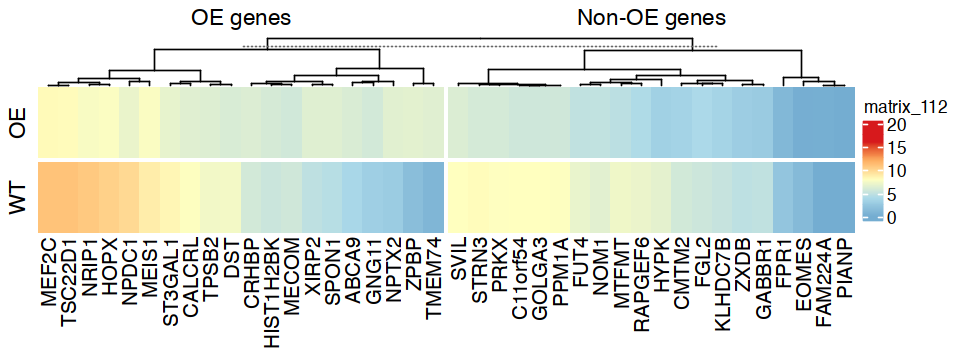

In [1704]:
col_panel = c('#74add1', "#abd9e9", '#ffffbf','#fdae61', '#d7191c')
col_fun = colorRamp2(c(0,4,8,12,16), col_panel)

options(repr.plot.width=8, repr.plot.height=3)
h <- Heatmap(rbind(colMeans(log2(S_bayesprism_n[1:6,gene_sel,'HSClike']+1)),
              colMeans(log2(S_bayesprism_n[7:13,gene_sel,'HSClike']+1))),
        row_split = c('WT','OE'), column_split = groups_gene,  cluster_rows = F, col=col_fun)
pdf('results/fig4/heatmap_celltype_expr_BayesPrism_HSClike_avgGroups_fc2.pdf', width=8, height=3) ; h ; dev.off()
h

pdf 
  2

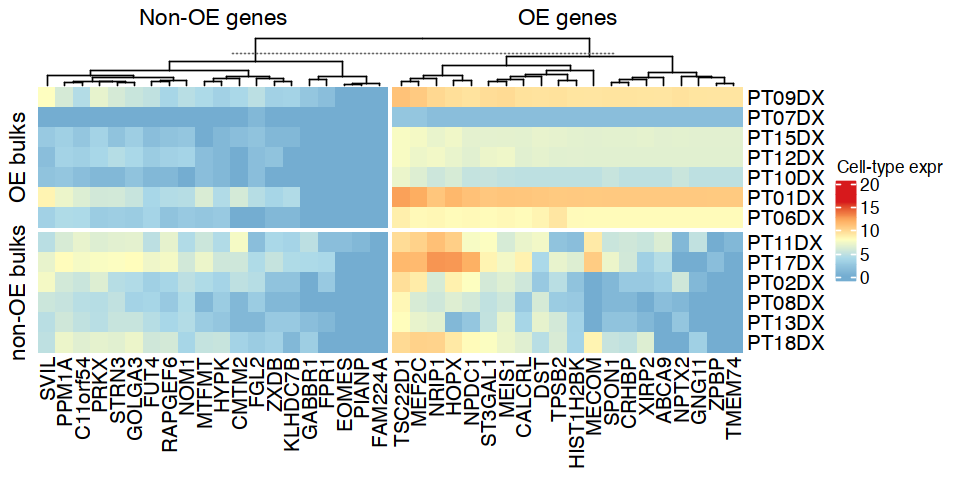

In [1705]:
options(repr.plot.width=8, repr.plot.height=4)
h <- Heatmap(log2(S_true_NA[,gene_sel,'HSClike']+1), 
        row_split = c(rep('non-OE bulks',6), rep('OE bulks', 7)), column_split = groups_gene,
        cluster_rows = F, col=col_fun, name='Cell-type expr')
pdf('results/fig4/heatmap_celltype_expr_TRUE_HSClike_fc2.pdf', width=8, height=4) ; h ; dev.off()
h <- draw(h)

In [1706]:
row_h = row_order(h) ; col_h = column_order(h)
row_h = c(row_h$`non-OE bulks`, row_h$`OE bulks`)
col_h = c(col_h$`OE genes`, col_h$`Non-OE genes`)

pdf 
  2

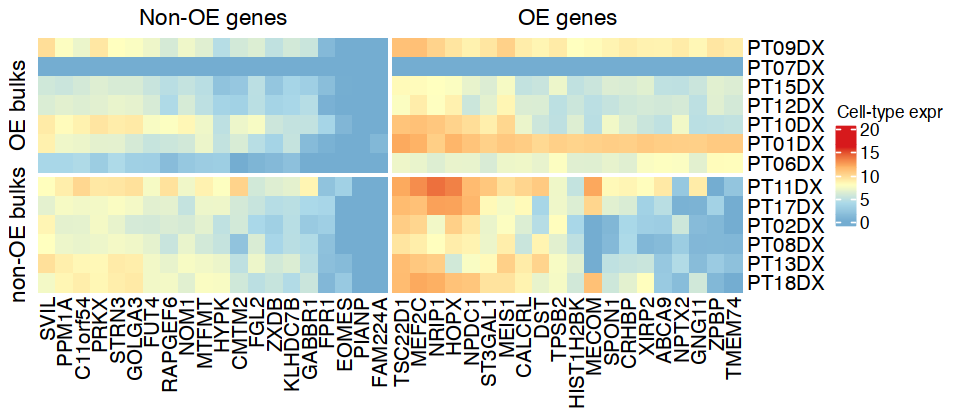

In [1707]:
options(repr.plot.width=8, repr.plot.height=3.5)
h <- Heatmap(log2(S_bayesprism_n[,gene_sel,'HSClike']+1)[row_h, col_h], 
        row_split = c(rep('non-OE bulks',6), rep('OE bulks', 7)), column_split = groups_gene,
        cluster_rows = F, cluster_columns=F, col=col_fun, name='Cell-type expr')
pdf('results/fig4/heatmap_celltype_expr_BayesPrism_HSClike_fc2.pdf', width=8, height=3.5) ; h ; dev.off()
h

In [1708]:
### Plot TRUE cell-type expression average per groups (OE and WT) in each cell-types
celltype_avg_oe_l = list() ; celltype_avg_wt_l = list()
for(k in 1:length(dimnames(S_bayesprism_n)[[3]])){
    this_celltype = dimnames(S_bayesprism_n)[[3]][k]
    celltype_avg_wt_l[[k]] = colMeans(log2(S_bayesprism_n[1:6,gene_sel,this_celltype]+1))
    celltype_avg_oe_l[[k]] = colMeans(log2(S_bayesprism_n[7:13,gene_sel,this_celltype]+1))
}
cell_avg_oe.true = do.call(rbind, celltype_avg_oe_l)
cell_avg_wt.true = do.call(rbind, celltype_avg_wt_l)
celltype_avg.true = rbind(cell_avg_oe.true, cell_avg_wt.true)
rownames(celltype_avg.true) = rep(dimnames(S_bayesprism_n)[[3]], 2)

pdf 
  2

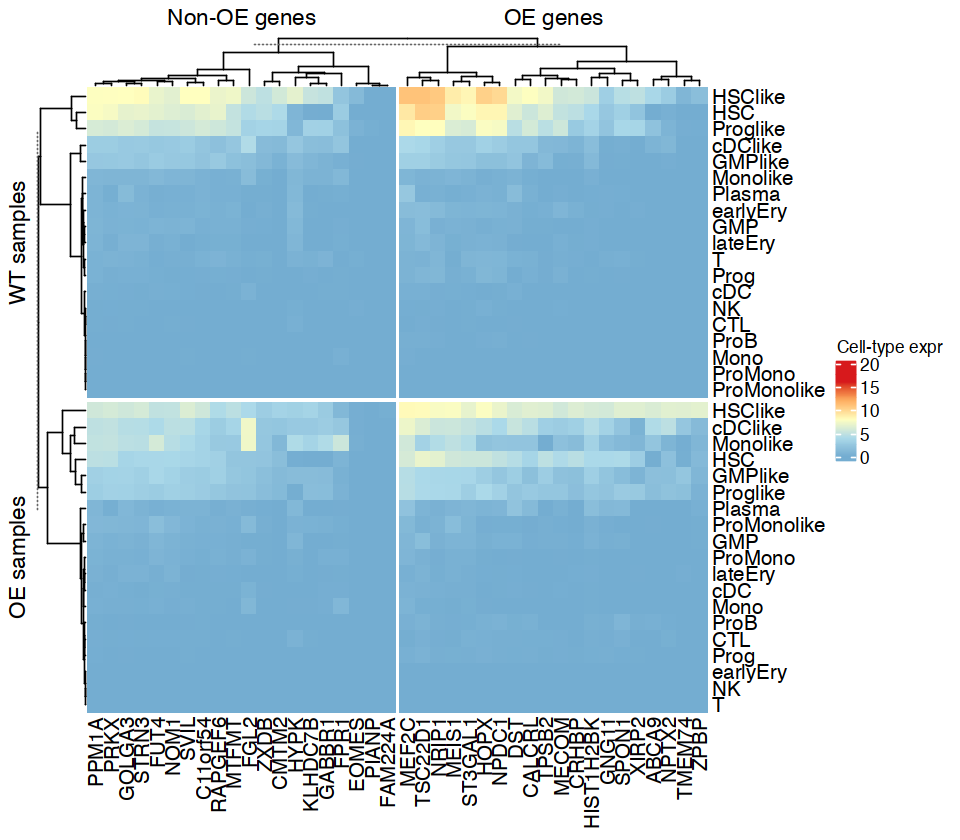

In [1709]:
options(repr.plot.width=8, repr.plot.height=7)
h <- Heatmap(celltype_avg.true, row_split = c(rep('OE samples',19), rep('WT samples', 19)), column_split = groups_gene,
        col=col_fun, name='Cell-type expr')
pdf('results/fig4/heatmap_celltype_expr_BayesPrism_avg_per_ct_fc2.pdf', width=8.5, height=6.8) ; h ; dev.off()
h

### analysis to assess accuracy of BayesPrism deconvoluted expression with varying fold changes

In [1780]:
library(DESeq2) ; library(precrec)
fold_changes = c('fc2', 'fc5', 'fc10', 'fc100', 'fc1000')
highres_cor_bayesprism = list()
highres_auc_celltype_bayesprism = list()
highres_auc_pergene_bayesprism = list()
for(i in 1:length(fold_changes)){
    fc = fold_changes[i]
    s_true_file = paste0('data/expression_deconv/AML_naldini_TRUE_EXPR_OE_n7to13_',fc,'.RDS')
    S_true_NA = readRDS(s_true_file)
    bayesprism_expr_file = paste0('data/expression_deconv/bayesprism_expr_',fc,'.RDS')
    bayesprism_expr = readRDS(bayesprism_expr_file)
    bayesprism_expr.sub = bayesprism_expr[,gene_selection,grepl('like',dimnames(bayesprism_expr)[[3]])]
    S_true_NA.sub = S_true_NA[,gene_selection,grepl('like',dimnames(S_true_NA)[[3]])]
    highres_cor_bayesprism[[i]] = cor(flatten(bayesprism_expr.sub), flatten(S_true_NA.sub))
    # compute AUC to detect DEGs
    S_mat <- round(bayesprism_expr.sub)
    fcs_ = matrix(0, nrow=dim(S_mat)[2], ncol=dim(S_mat)[3])
    pvals_ = matrix(0, nrow=dim(S_mat)[2], ncol=dim(S_mat)[3])
    padjs_ = matrix(0, nrow=dim(S_mat)[2], ncol=dim(S_mat)[3])
    conditions = c(rep('WT', 6), rep('OE', 7))
    for (k in 1:6) {
        S_k = S_mat[, , k]
        if (rankMatrix(S_k)[1] == 0) {
          if (verbose) {
            message("matrix not full ranked, skipping cell-type")
          }
          next
        }
        colData = data.frame(condition = conditions, tot_expr = rowSums(S_k))
        dds <- DESeqDataSetFromMatrix(countData = t(S_k) + 
          1, colData = colData, design = (~tot_expr + condition))
        dds <- tryCatch(expr = {
          DESeq(dds)
        }, error = function(cond) {
          if (verbose) {
            message("Error with DE analysis, using fit with mean instead")
          }
          return(DESeq(dds, fitType = "mean"))
        })
        fcs_[, k] = num(-1 * results(dds, tidy = TRUE)$log2FoldChange)
        pvals_[, k] = num(results(dds, tidy = TRUE)$pvalue)
        padjs_[, k] = num(results(dds, tidy = TRUE)$padj)
    }
    padjs = data.frame(padjs_)
    colnames(padjs) = dimnames(S_mat)[[3]]
    rownames(padjs) = dimnames(S_mat)[[2]]
    padjs = -log10(padjs)
    padjs[is.na(padjs)] <- 0
    fcs = data.frame(fcs_)
    colnames(fcs) = dimnames(S_mat)[[3]]
    rownames(fcs) = dimnames(S_mat)[[2]]
    fcs[is.na(fcs)] <- 0.0
    padjs$gene_name = rownames(padjs)
    padjs_melt = melt(padjs)
    colnames(padjs_melt) = c('gene', 'celltype', 'log_padj')
    fcs$gene_name = rownames(fcs)
    fcs_melt = melt(fcs)
    padjs_melt$fc = fcs_melt$value
    padjs_melt$type.true = 0
    # score used for AUC - significance * effect size (effect size must be positive since it's an over-expression)
    padjs_melt$score = padjs_melt$log_padj * padjs_melt$fc 
    padjs_melt[padjs_melt$gene %in% gene_to_induce & padjs_melt$celltype == 'HSClike',]$type.true <- 1
    padjs_melt.hsclike = padjs_melt[padjs_melt$celltype == 'HSClike',]
    # AUC for detecting DEGs among all genes in HSClike
    padjs_melt_ = padjs_melt.hsclike[padjs_melt.hsclike$gene %in% cancer_celltype_markers_all,]
    roc_score = evalmod(scores = padjs_melt_$score, labels = padjs_melt_$type.true, mode = "aucroc")
    highres_auc_celltype_bayesprism[[i]] = roc_score$uaucs$aucs
    # AUC for detecting DEGs in correct cell-type for each DEG
    highres_auc_1gene = list()
    for(g in 1:length(gene_to_induce)){
        gene = gene_to_induce[g]
        padjs_melt.1gene = padjs_melt[padjs_melt$gene == gene,]
        roc_score = evalmod(scores = padjs_melt.1gene$score, labels = padjs_melt.1gene$type.true, mode = "aucroc")
        highres_auc_1gene[[g]] = roc_score$uaucs$aucs
    }
    highres_auc_pergene_bayesprism[[i]] = mean(num(highres_auc_1gene))
}

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = 

final dispersion estimates

fitting model and testing

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersi

final dispersion estimates

fitting model and testing

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersi

final dispersion estimates

fitting model and testing

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersi

fitting model and testing

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captur

## Write tables for CiberSortX and load results

Only cancer cells are used since CiberSortX requires K < N (number of cell types < number of bulks).

In [1360]:
sc.es.vg.onlycancer = sc.es.vg[,grepl('like', sc.es.vg$cellType)]

In [1361]:
out_dir = 'data/expression_deconv/tables/'
write_tables_cibersortx_highres <- function(sc, bulks, true_prop, celltype_names, out_file_sc, out_file_bulk){
    # WARNING : the following script only writes tables to be used on CiberSortX website
    #sc_mat = exprs(sc)
    #colnames(sc_mat) = as.character(sc$cellType) # cell-type labels provided as column names
    #write.table(sc_mat , out_file_sc, sep = '\t', quote=F)
    write.table(exprs(bulks), out_file_bulk, sep = '\t', quote=F)
}

In [1363]:
bulk.es.na.overexpression = readRDS('data/expression_deconv/AML_naldini_pbulks_vg_labs_es_OE_n7to13_fc2.RDS')
# write tables for CiberSortX (still needs to be post-processed by adding 'Gene' in column 1)
write_tables_cibersortx_highres(sc.es.vg.onlycancer, bulk.es.na.overexpression, pData(bulk.es.na), levels(factor(sc.es.vg$cellType)),
                        out_file_sc = paste0(out_dir, 'TMP_cibersortx_sc_mat_vg2na_OE_fc2.txt'),
                        out_file_bulk = paste0(out_dir, 'TMP_cibersortx_pbulks_vg2na_OE_fc2.txt'))

In [713]:
# Make a list of genes for CiberSortX high-resolution mode
set.seed(10)
random_sel = sample(dimnames(climb_expr)[[2]][!dimnames(climb_expr)[[2]] %in% gene_to_induce], 20)
gene_sel = c(gene_to_induce, random_sel)
# We load signature genes from Van Galen et al. and we add the 40 genes used in previous analysis
vangalen_signature = read.csv('data/aml_3cohorts/cancer_cell_type_signature.csv')
cancer_celltype_markers_all = flatten(vangalen_signature)
cancer_celltype_markers_all = unique(c(cancer_celltype_markers_all, gene_sel))
all(gene_sel %in% cancer_celltype_markers_all)

[1] "MEIS1"     "NPTX2"     "GNG11"     "NRIP1"     "ABCA9"     "MEF2C"    
 [7] "NPDC1"     "TMEM74"    "ZPBP"      "ST3GAL1"   "HIST1H2BK" "DST"      
[13] "XIRP2"     "SPON1"     "HOPX"      "CRHBP"     "TSC22D1"   "TPSB2"    
[19] "CALCRL"    "MECOM"     "C11orf54"  "RAPGEF6"   "PIANP"     "SVIL"     
[25] "FPR1"      "FAM224A"   "PRKX"      "GOLGA3"    "STRN3"     "PPM1A"    
[31] "ZXDB"      "CMTM2"     "FGL2"      "GABBR1"    "HYPK"      "EOMES"    
[37] "KLHDC7B"   "MTFMT"     "FUT4"      "NOM1"

In [724]:
write.csv(cancer_celltype_markers_all, 'data/expression_deconv/tables/cibersortx_list_genes_highresolution_OE_analysis.csv', 
          quote=F, row.names=F, col.names=F)

Warning message in write.csv(cancer_celltype_markers_all, "data/expression_deconv/tables/cibersortx_list_genes_highresolution_OE_analysis.csv", :
“attempt to set 'col.names' ignored”


### Load CiberSortX results

In [1792]:
csx_res_dir = 'data/expression_deconv/tables/cibersortx_highres_fc10'
list_files = list.files(csx_res_dir)
list_files = list_files[grepl('like', list_files)]
celltypes_files = gsub('CIBERSORTxHiRes_','',list_files)
celltypes_files = gsub('Job[0-9][0-9]_','',celltypes_files)
celltypes_files = gsub('_.*','',celltypes_files)

celltypes_files

all_mats = list()
for(k in 1:length(celltypes_files)){
    this_file = list_files[[k]]
    this_celltype = celltypes_files[[k]]
    all_mats[[k]] = as.matrix(read.csv(paste0(csx_res_dir, '/', this_file), sep='\t', row.names='GeneSymbol'))
}

[1] "GMPlike"     "HSClike"     "Monolike"    "ProMonolike" "Proglike"   
[6] "cDClike"

In [1793]:
set.seed(10)
random_sel = sample(dimnames(climb_expr)[[2]][!dimnames(climb_expr)[[2]] %in% gene_to_induce], 20)
gene_sel = c(gene_to_induce, random_sel)
groups_gene = c(rep('OE genes', length(gene_to_induce.bp)), rep('Non-OE genes', length(random_sel)))

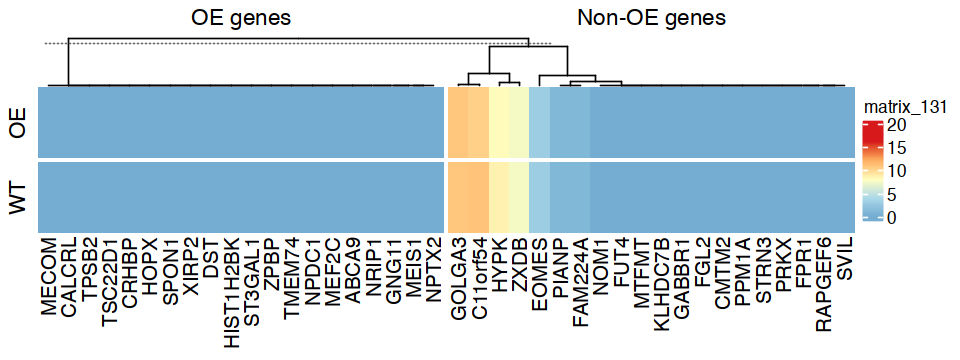

In [1794]:
col_panel = c('#74add1', "#abd9e9", '#ffffbf','#fdae61', '#d7191c')
col_fun = colorRamp2(c(0,4,8,12,16), col_panel)

mat_means = rbind(colMeans(log2(hsclike_mat[1:6,gene_sel]+1), na.rm = T),
                  colMeans(log2(hsclike_mat[7:13,gene_sel]+1), na.rm = T))
mat_means[is.na(mat_means)] <- 0

options(repr.plot.width=8, repr.plot.height=3)
h <- Heatmap(mat_means,row_split = c('WT','OE'), column_split = groups_gene,  cluster_rows = F, col=col_fun)
#pdf('results/fig4/heatmap_celltype_expr_BayesPrism_HSClike_avgGroups.pdf', width=8, height=3) ; h ; dev.off()
h

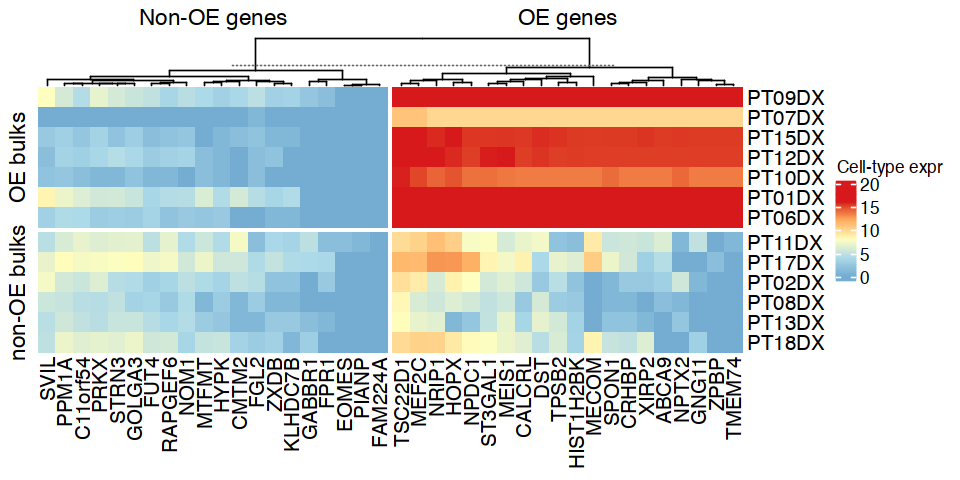

In [1795]:
options(repr.plot.width=8, repr.plot.height=4)
h <- Heatmap(log2(S_true_NA[,gene_sel,'HSClike']+1), 
        row_split = c(rep('non-OE bulks',6), rep('OE bulks', 7)), column_split = groups_gene,
        cluster_rows = F, col=col_fun, name='Cell-type expr')
h <- draw(h)

In [1796]:
row_h = row_order(h) ; col_h = column_order(h)
row_h = c(row_h$`non-OE bulks`, row_h$`OE bulks`)
col_h = c(col_h$`OE genes`, col_h$`Non-OE genes`)

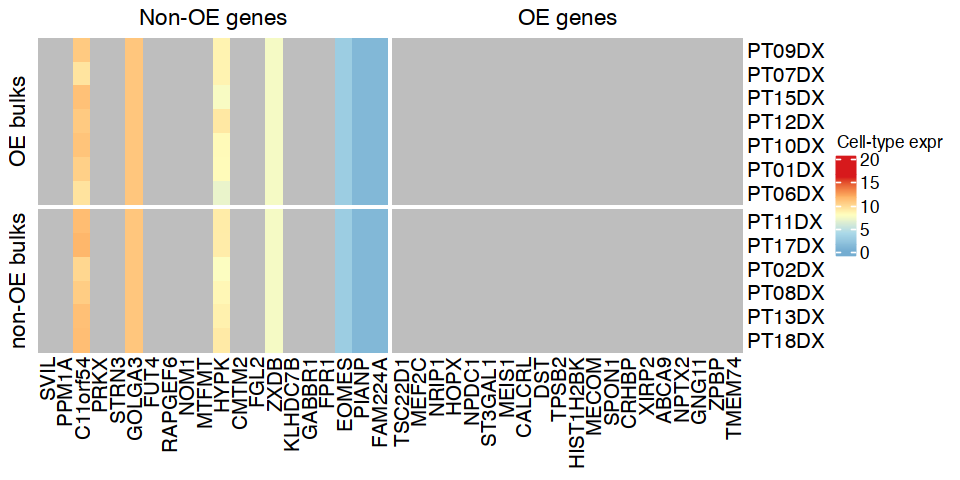

In [1797]:
options(repr.plot.width=8, repr.plot.height=4)
h <- Heatmap(log2(hsclike_mat[,gene_sel]+1)[row_h, col_h], 
        row_split = c(rep('non-OE bulks',6), rep('OE bulks', 7)), column_split = groups_gene,
        cluster_rows = F, cluster_columns=F, col=col_fun, name='Cell-type expr')
#pdf('results/fig4/heatmap_celltype_expr_BayesPrism_HSClike_fc100.pdf', width=8, height=4) ; h ; dev.off()
h

In [1832]:
### Plot TRUE cell-type expression average per groups (OE and WT) in each cell-types
celltype_avg_oe_l = list() ; celltype_avg_wt_l = list()
for(k in 1:6){
    this_celltype = dimnames(S_bayesprism_n)[[3]][k]
    celltype_avg_wt_l[[k]] = colMeans(t(log2(all_mats[[k]][gene_sel,1:6]+1)), na.rm = T)
    celltype_avg_oe_l[[k]] = colMeans(t(log2(all_mats[[k]][gene_sel,7:13]+1)), na.rm = T)
}
cell_avg_oe.true = do.call(rbind, celltype_avg_oe_l)
cell_avg_wt.true = do.call(rbind, celltype_avg_wt_l)
celltype_avg.true = rbind(cell_avg_oe.true, cell_avg_wt.true)
rownames(celltype_avg.true) = rep(celltypes_files, 2)

In [1834]:
celltype_avg.true[is.na(celltype_avg.true)] <- 0

pdf 
  2

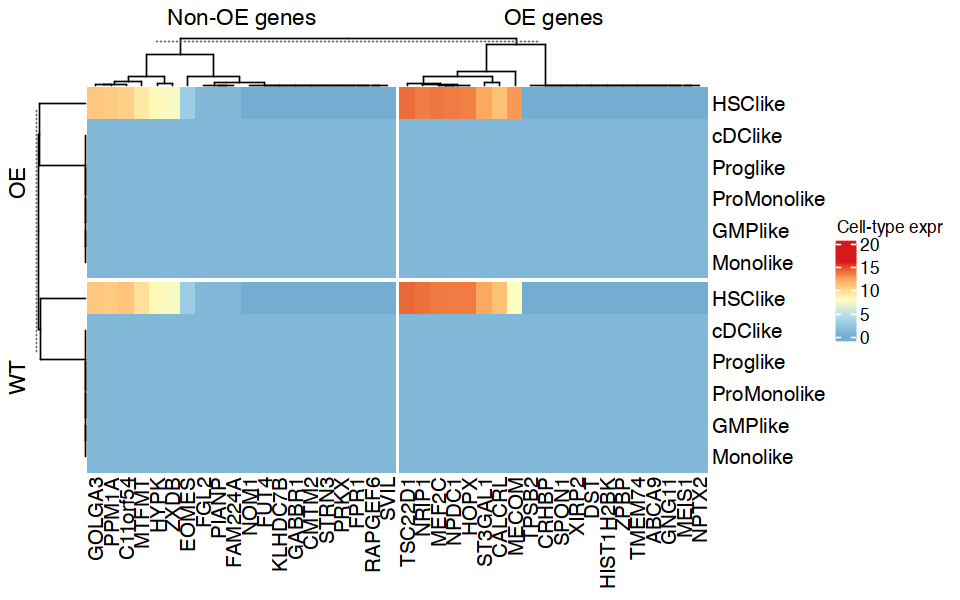

In [1838]:
options(repr.plot.width=8, repr.plot.height=5)
h <- Heatmap(celltype_avg.true, row_split = c(rep('OE',6), rep('WT', 6)), 
             column_split = c(rep('OE genes', 20), rep('Non-OE genes', 20)),
        col=col_fun, name='Cell-type expr')
pdf('results/fig4/heatmap_celltype_expr_CiberSortX_avg_per_ct_fc10.pdf', width=8.5, height=6.8) ; h ; dev.off()
h

### Run CiberSortX with all fold changes 

In [1781]:
library(DESeq2) ; library(precrec)
fold_changes = c('fc2', 'fc5', 'fc10', 'fc100', 'fc1000')
highres_cor_cibersortx = list()
highres_auc_celltype_cibersortx = list()
highres_auc_pergene_cibersortx = list()
for(i in 1:length(fold_changes)){
    fc = fold_changes[i]
    s_true_file = paste0('data/expression_deconv/AML_naldini_TRUE_EXPR_OE_n7to13_',fc,'.RDS')
    S_true_NA = readRDS(s_true_file)
    csx_res_dir = paste0('data/expression_deconv/tables/cibersortx_highres_', fc)
    list_files = list.files(csx_res_dir)
    list_files = list_files[grepl('like', list_files)]
    celltypes_files = gsub('CIBERSORTxHiRes_','',list_files)
    celltypes_files = gsub('Job[0-9][0-9]_','',celltypes_files)
    celltypes_files = gsub('_.*','',celltypes_files)
    all_melts = list() ; all_mats = list()
    for(k in 1:length(celltypes_files)){
        this_file = list_files[[k]]
        this_celltype = celltypes_files[[k]]
        df_this_celltype = read.csv(paste0(csx_res_dir, '/', this_file), sep='\t', row.names='GeneSymbol')
        all_mats[[k]] = as.matrix(df_this_celltype)
        df_this_celltype$celltype = this_celltype
        df_this_celltype$gene = rownames(df_this_celltype)
        all_melts[[k]] = melt(df_this_celltype)
    }
    csx_expr_melt = do.call(rbind,all_melts)
    csx_expr_melt$uniq_id = paste0(csx_expr_melt$variable, csx_expr_melt$celltype, csx_expr_melt$gene)
    S_true_NA.sub = S_true_NA[,dimnames(S_true_NA)[[2]] %in% unique(csx_expr_melt$gene),]
    S_true_NA.sub = S_true_NA.sub[,,celltypes_files]
    S_true_NA.melt = melt(S_true_NA.sub)
    colnames(S_true_NA.melt) = c('sample', 'gene', 'celltype', 'value')
    S_true_NA.melt$uniq_id = paste0(S_true_NA.melt$sample, S_true_NA.melt$celltype, S_true_NA.melt$gene)
    all(csx_expr_melt$uniq_id %in% S_true_NA.melt$uniq_id) & 
    all(S_true_NA.melt$uniq_id %in% csx_expr_melt$uniq_id)
    rownames(S_true_NA.melt) = S_true_NA.melt$uniq_id
    S_true_NA.melt = S_true_NA.melt[csx_expr_melt$uniq_id,]
    all(rownames(S_true_NA.melt) == csx_expr_melt$uniq_id)
    highres_cor_cibersortx[[i]] = cor(S_true_NA.melt$value, csx_expr_melt$value, use="complete.obs")
    ## compute AUC to detect DEGs
    fcs_ = matrix(0, nrow=dim(all_mats[[1]])[1], ncol=6)
    pvals_ = matrix(0, nrow=dim(all_mats[[1]])[1], ncol=6)
    padjs_ = matrix(0, nrow=dim(all_mats[[1]])[1], ncol=6)
    conditions = c(rep('WT', 6), rep('OE', 7))
    for (k in 1:6) {
        S_k = t(all_mats[[k]])
        S_k[is.na(S_k)] <- 0
        S_k = round(S_k)
        if (all(S_k == 1)){
            fcs_[, k] = 0.0
            pvals_[, k] = 1.0
            padjs_[, k] = 1.0
        } else {
            colData = data.frame(condition = conditions, tot_expr = rowSums(S_k))
            dds <- DESeqDataSetFromMatrix(countData = t(S_k) + 
              1, colData = colData, design = (~tot_expr + condition))
            dds <- tryCatch(expr = {
              DESeq(dds)
            }, error = function(cond) {
              if (verbose) {
                message("Error with DE analysis, using fit with mean instead")
              }
              return(DESeq(dds, fitType = "mean"))
            })
            fcs_[, k] = num(results(dds, tidy = TRUE)$log2FoldChange)
            pvals_[, k] = num(results(dds, tidy = TRUE)$pvalue)
            padjs_[, k] = num(results(dds, tidy = TRUE)$padj)
        }
    }
    padjs = data.frame(padjs_)
    colnames(padjs) = celltypes_files
    rownames(padjs) = rownames(all_mats[[1]])
    padjs = -log10(padjs)
    padjs[is.na(padjs)] <- 0
    fcs = data.frame(fcs_)
    colnames(fcs) = celltypes_files
    rownames(fcs) = rownames(all_mats[[1]])
    fcs[is.na(fcs)] <- 0.0
    padjs$gene_name = rownames(padjs)
    padjs_melt = melt(padjs)
    colnames(padjs_melt) = c('gene', 'celltype', 'log_padj')
    fcs$gene_name = rownames(fcs)
    fcs_melt = melt(fcs)
    padjs_melt$fc = fcs_melt$value
    padjs_melt$type.true = 0
    # score used for AUC - significance * effect size (effect size must be positive since it's an over-expression)
    padjs_melt$score = padjs_melt$log_padj * padjs_melt$fc 
    padjs_melt[padjs_melt$gene %in% gene_to_induce & padjs_melt$celltype == 'HSClike',]$type.true <- 1
    padjs_melt.hsclike = padjs_melt[padjs_melt$celltype == 'HSClike',]
    # AUC for detecting DEGs among all genes in HSClike
    padjs_melt_ = padjs_melt.hsclike[padjs_melt.hsclike$gene %in% cancer_celltype_markers_all,]
    roc_score = evalmod(scores = padjs_melt_$score, labels = padjs_melt_$type.true, mode = "aucroc")
    highres_auc_celltype_cibersortx[[i]] = roc_score$uaucs$aucs
    # AUC for detecting DEGs in correct cell-type for each DEG
    highres_auc_1gene = list()
    for(g in 1:length(gene_to_induce)){
        gene = gene_to_induce[g]
        padjs_melt.1gene = padjs_melt[padjs_melt$gene == gene,]
        roc_score = evalmod(scores = padjs_melt.1gene$score, labels = padjs_melt.1gene$type.true, mode = "aucroc")
        highres_auc_1gene[[g]] = roc_score$uaucs$aucs
    }
    highres_auc_pergene_cibersortx[[i]] = mean(num(highres_auc_1gene))
}

Using celltype, gene as id variables

Using celltype, gene as id variables

Using celltype, gene as id variables

Using celltype, gene as id variables

Using celltype, gene as id variables

Using celltype, gene as id variables

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM

  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting 

# Compare CLIMB / BayesPrism / CiberSortX 

In [1785]:
df_auc_celltype = data.frame(`True Expression`=do.call(c, highres_auc_celltype_true),
                    BayesPrism=do.call(c,highres_auc_celltype_bayesprism),
                    CLIMB=do.call(c,highres_auc_celltype_climb),
                    CiberSortX=do.call(c,highres_auc_celltype_cibersortx),
                    Random=do.call(c,highres_auc_celltype_random))
rownames(df_auc_celltype) = fold_changes
df_auc_gene = data.frame(`True Expression`=do.call(c, highres_auc_pergene_true),
                    BayesPrism=do.call(c,highres_auc_pergene_bayesprism),
                    CLIMB=do.call(c,highres_auc_pergene_climb),
                    CiberSortX=do.call(c,highres_auc_pergene_cibersortx),
                    random=do.call(c,highres_auc_pergene_random))
rownames(df_auc_gene) = fold_changes
df_pcc = data.frame(CLIMB=do.call(c,highres_cor_climb),
                    BayesPrism=do.call(c,highres_cor_bayesprism),
                    CiberSortX=do.call(c,highres_cor_cibersortx))
rownames(df_pcc) = fold_changes

pdf 
  2

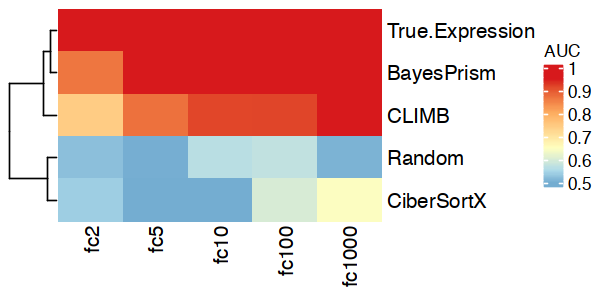

In [1854]:
col_panel = c('#74add1', "#abd9e9", '#ffffbf','#fdae61', '#d7191c')
col_fun = colorRamp2(c(0.5,0.55,0.65,0.8,0.95), col_panel)
options(repr.plot.width=5, repr.plot.height=2.5)
h <- Heatmap(t(df_auc_celltype), cluster_columns=F, col=col_fun, name='AUC')
pdf('results/fig4/heatmap_comparisonFCs_highres_AUC_perCellType.pdf', width=5, height=2.5) ; h ; dev.off()
h

In [1860]:
df_auc_celltype$CLIMB

[1] 0.7440299 0.8746269 0.9191542 0.9201493 0.9982587

pdf 
  2

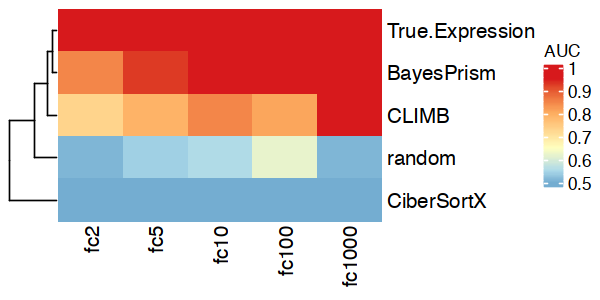

In [1852]:
col_panel = c('#74add1', "#abd9e9", '#ffffbf','#fdae61', '#d7191c')
#col_fun = colorRamp2(c(0.4,0.55,0.7,0.85,1.0), col_panel)
options(repr.plot.width=5, repr.plot.height=2.5)
h <- Heatmap(t(df_auc_gene), cluster_columns=F, col=col_fun, name='AUC')
pdf('results/fig4/heatmap_comparisonFCs_highres_AUC_perGene.pdf', width=5, height=2.5) ; h ; dev.off()
h

In [1858]:
df_auc_gene

,True.Expression,BayesPrism,CLIMB,CiberSortX,random
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
fc2,1,0.85,0.73,0.10,0.510
fc5,1,0.93,0.79,0.05,0.540
fc10,1,0.99,0.85,0.00,0.555
fc100,1,1.00,0.81,0.00,0.620
fc1000,1,1.00,0.97,0.00,0.510


No id variables; using all as measure variables



pdf 
  2

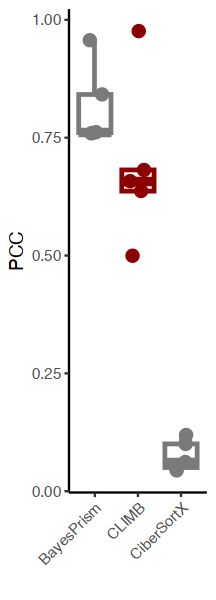

In [1653]:
df_pcc_melt = melt(df_pcc)
df_pcc_melt$variable = factor(df_pcc_melt$variable, levels=c('BayesPrism', 'CLIMB', 'CiberSortX'))
options(repr.plot.width=1.8, repr.plot.height=5)
g <- ggplot(df_pcc_melt, aes(x=variable, y=value, color=variable)) + 
    geom_boxplot(outlier.shape=NA, size=1) + 
    geom_jitter(size=3, width=0.2) + scale_color_manual(values=c('grey48', 'darkred', 'grey48'), guide='none') +
    theme_classic()+ theme(axis.text.x = element_text(angle = 45, hjust=1.0, vjust=1.0)) +
    ylab('PCC')+ xlab('')
pdf('results/fig4/boxplot_comparisonPCC_highres.pdf', width=1.8, height=5) ; g ; dev.off()
g

In [1862]:
aggregate(df_pcc_melt$value, list(df_pcc_melt$variable), median)

Group.1,x
<fct>,<dbl>
BayesPrism,0.76183403
CLIMB,0.65758193
CiberSortX,0.06193744
